<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/7_Seasonality_Hour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this notebook we look at intraday seasonality effects

In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = FALSE, extra_libraries = c('lubridate', 'roll', 'RcppRoll', 'QuantTools'), extra_dependencies = c('RcppParallel'))

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



-- R CMD build -----------------------------------------------------------------
* checking for file /tmp/RtmpGw10vC/remotes1ad6561c73d/RWLab-rwRtools-1924b0b/DESCRIPTION ... OK
* preparing rwRtools:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted LazyData from DESCRIPTION
  NB: this package now depends on R (>= 3.5.0)
  serialize/load version 3 cannot be read in older versions of R.
  File(s) containing such objects:
    rwRtools/R/sysdata.rda
* building rwRtools_0.1.33.tar.gz



In [2]:
# snippet: rw data auth v.0.1
rwlab_data_auth()

Authorization successful!

# Interesting Intro Crypto Research

I want to look quickly at a few interesting ideas:
 - Hours of a day seasonality effects

In [3]:
perp <- crypto_get_futures()
funding <- crypto_get_perp_rates()
spot <- crypto_get_spot()


i Downloading ftx_futures_ohlc_1h.feather

v Saved ftx_futures_ohlc_1h.feather to ftx/ftx_futures_ohlc_1h.feather  ( 232...





File successfully transferred


i Downloading ftx_perpetual_funding_rates.feather

v Saved ftx_perpetual_funding_rates.feather to ftx/ftx_perpetual_funding_rate...





File successfully transferred


i Downloading ftx_spot_ohlc_1h.feather

v Saved ftx_spot_ohlc_1h.feather to ftx/ftx_spot_ohlc_1h.feather  ( 753.2 Mb )





File successfully transferred


In [4]:
spot %>%
  head()

ticker,date,open,high,low,close,volume
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1INCH/USD,2020-12-25 05:00:00,2.3956,2.9716,2.30955,2.5893,53413.45
1INCH/USD,2020-12-25 06:00:00,2.5893,2.6400,2.22560,2.5190,58925.92
1INCH/USD,2020-12-25 07:00:00,2.5190,2.8000,2.34990,2.6067,87704.12
1INCH/USD,2020-12-25 08:00:00,2.6067,2.7750,2.48290,2.6019,89654.50
1INCH/USD,2020-12-25 09:00:00,2.6019,2.7600,2.48210,2.6739,42066.59
1INCH/USD,2020-12-25 10:00:00,2.6739,2.9591,2.65150,2.7959,69676.92


In [5]:
universe <- c(
  'BTC/USD','ETH/USD','XRP/USD','BCH/USD','DOGE/USD','LINK/USD','LTC/USD',
  'RAY/USD','SOL/USD','FTT/USD','UNI/USD','SUSHI/USD','BNB/USD','MATIC/USD','SRM/USD', 'AAVE/USD')


#Seasonality


In [6]:
hourly_seasonality <- spot %>% 
  group_by(ticker) %>%
  mutate(
    year = lubridate::year(date),
    hour = lubridate::hour(date),
    day_of_week = lubridate::wday(date), 
    logvolume = log(volume+1),
    c2c_logreturn = log(close/lag(close)),
    logrange = log(high/low)
  ) %>%
  na.omit() 

We expect to see most of the activity when US wakes up... which corresponds to 13 UTC hour

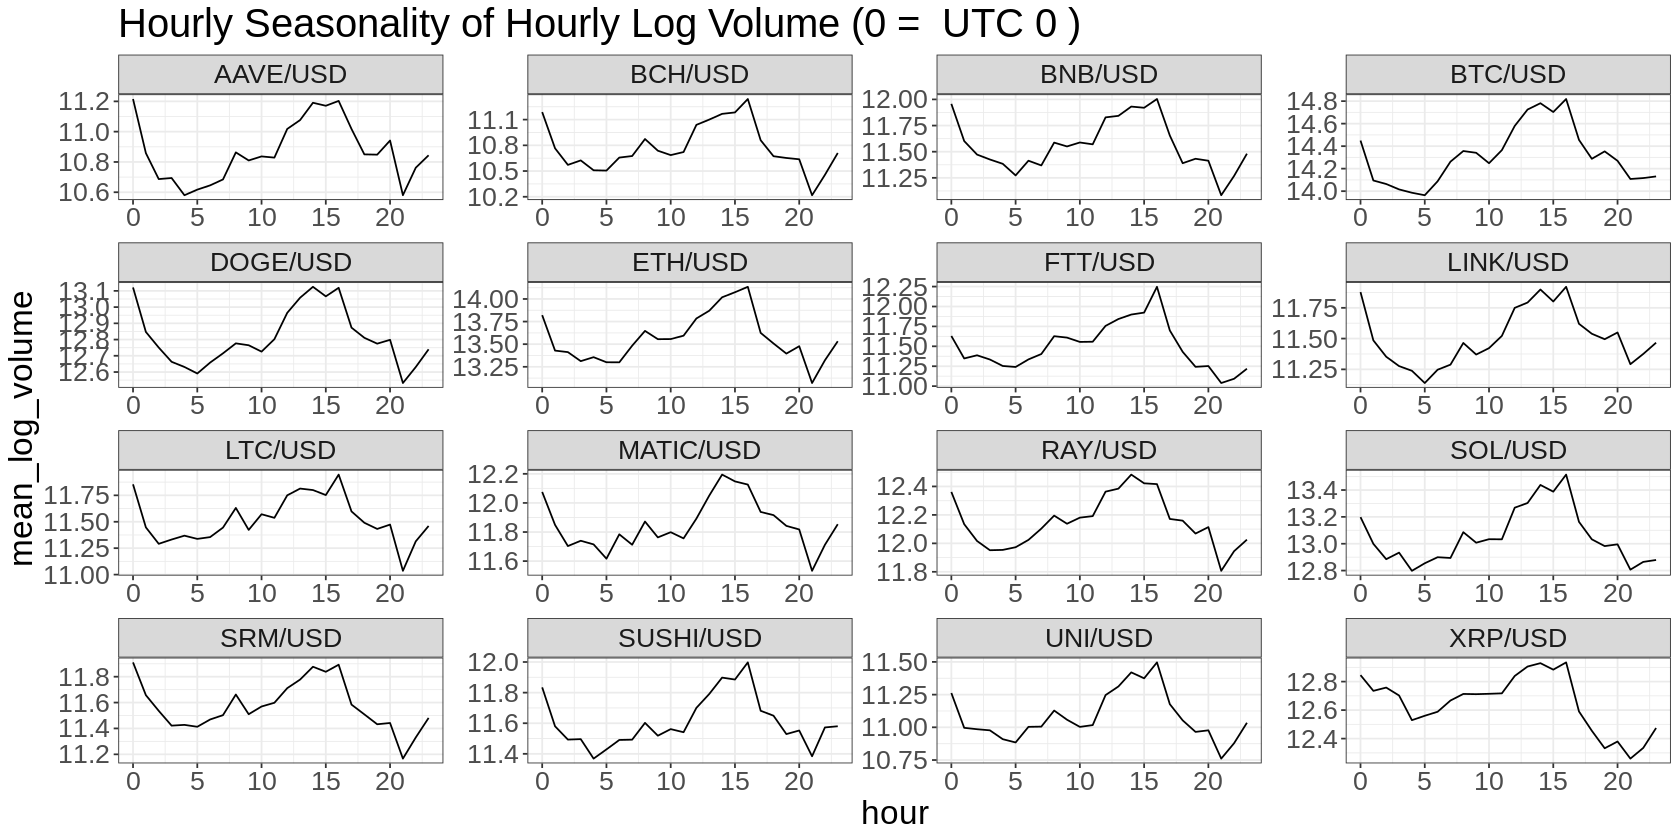

In [7]:
hourly_seasonality %>%
  filter(ticker %in% universe) %>%
  group_by(ticker, hour) %>%
  mutate(mean_log_volume = mean(logvolume)) %>%
  ggplot(aes(x=hour, y=mean_log_volume)) +
  geom_line() +
  ggtitle('Hourly Seasonality of Hourly Log Volume (0 =  UTC 0 )') +
  facet_wrap(~ticker, scales = 'free') 

Interesting the lowest point seems constitently at 15 hour UTC 

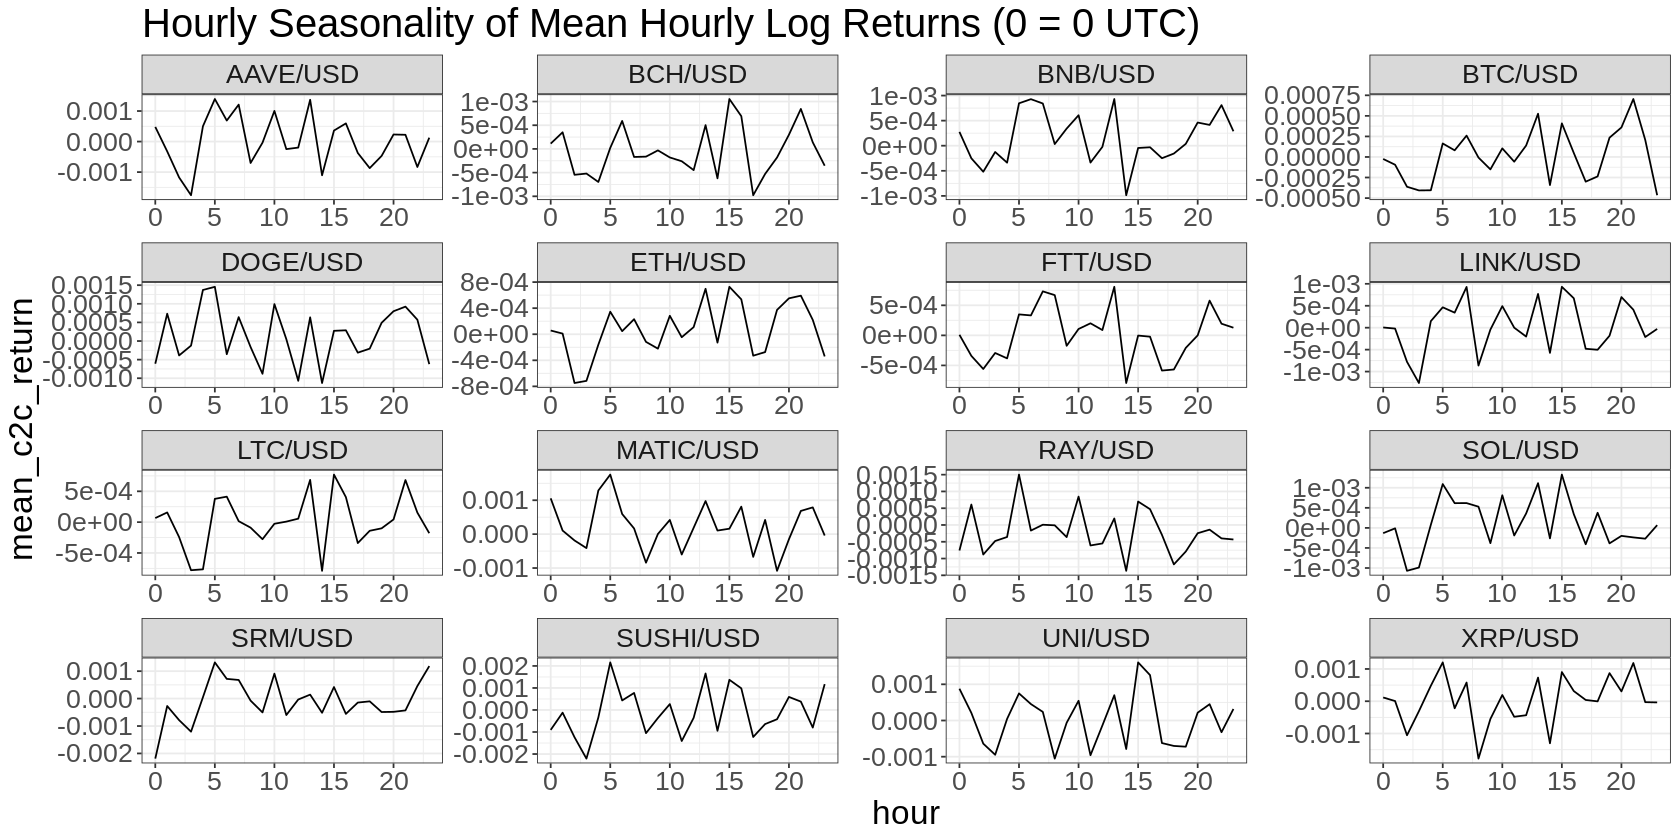

In [8]:
hourly_seasonality %>%
  filter(ticker %in% universe) %>%
  group_by(ticker, hour) %>%
  mutate(mean_c2c_return = mean(c2c_logreturn)) %>%
  ggplot(aes(x=hour, y=mean_c2c_return)) +
  geom_line() +
  ggtitle('Hourly Seasonality of Mean Hourly Log Returns (0 = 0 UTC)') +
  facet_wrap(~ticker, scales='free')

5 hour looks interesing so does hour 20...


# BTC Hour seasonality effect

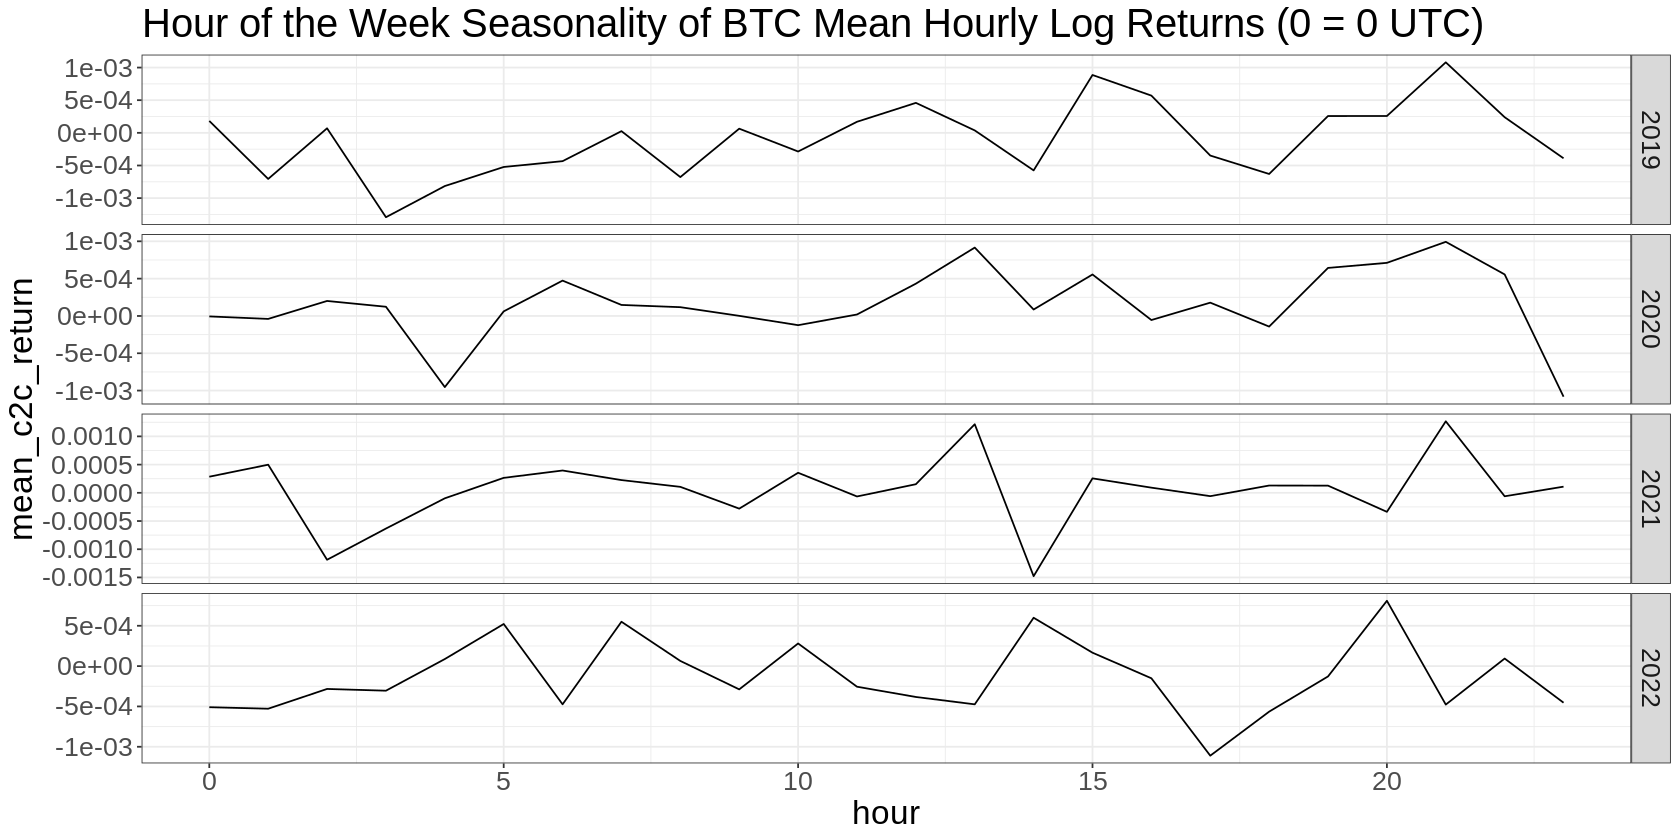

In [9]:
hourly_seasonality %>%
  filter(ticker == 'BTC/USD') %>%
  group_by(ticker, year, hour) %>%
  mutate(mean_c2c_return = mean(c2c_logreturn)) %>%
  ggplot(aes(x=hour, y=mean_c2c_return)) +
  geom_line() +
  ggtitle('Hour of the Week Seasonality of BTC Mean Hourly Log Returns (0 = 0 UTC)') +
  facet_grid(rows= vars(year), scales='free')

And create some equity curves for "trading long on a hour of a day"

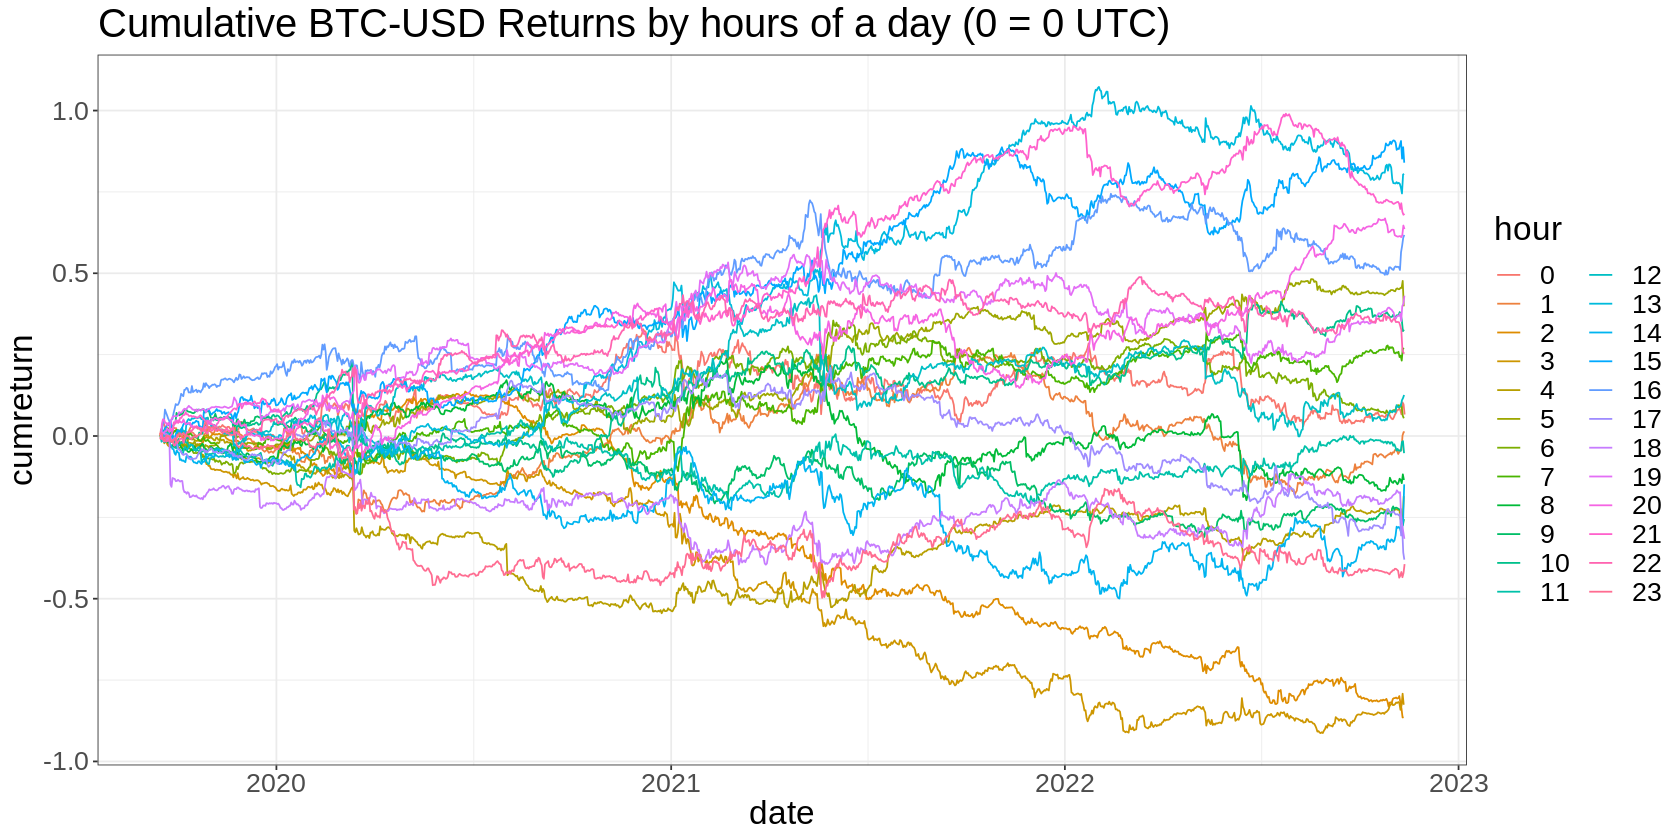

In [10]:
spot %>%
  filter(ticker == 'ETH/USD') %>%
  arrange(date) %>%
  mutate(
    hour = factor(lubridate::hour(date)), 
    c2c_logreturn = log(close/lag(close)),
  ) %>%
  na.omit() %>%
  group_by(hour) %>%
  mutate(cumreturn = cumsum(c2c_logreturn)) %>%
  ggplot(aes(x=date, y=cumreturn, color=hour)) + 
    geom_line() +
    ggtitle('Cumulative BTC-USD Returns by hours of a day (0 = 0 UTC)')

`summarise()` has grouped output by 'ticker'. You can override using the
`.groups` argument.


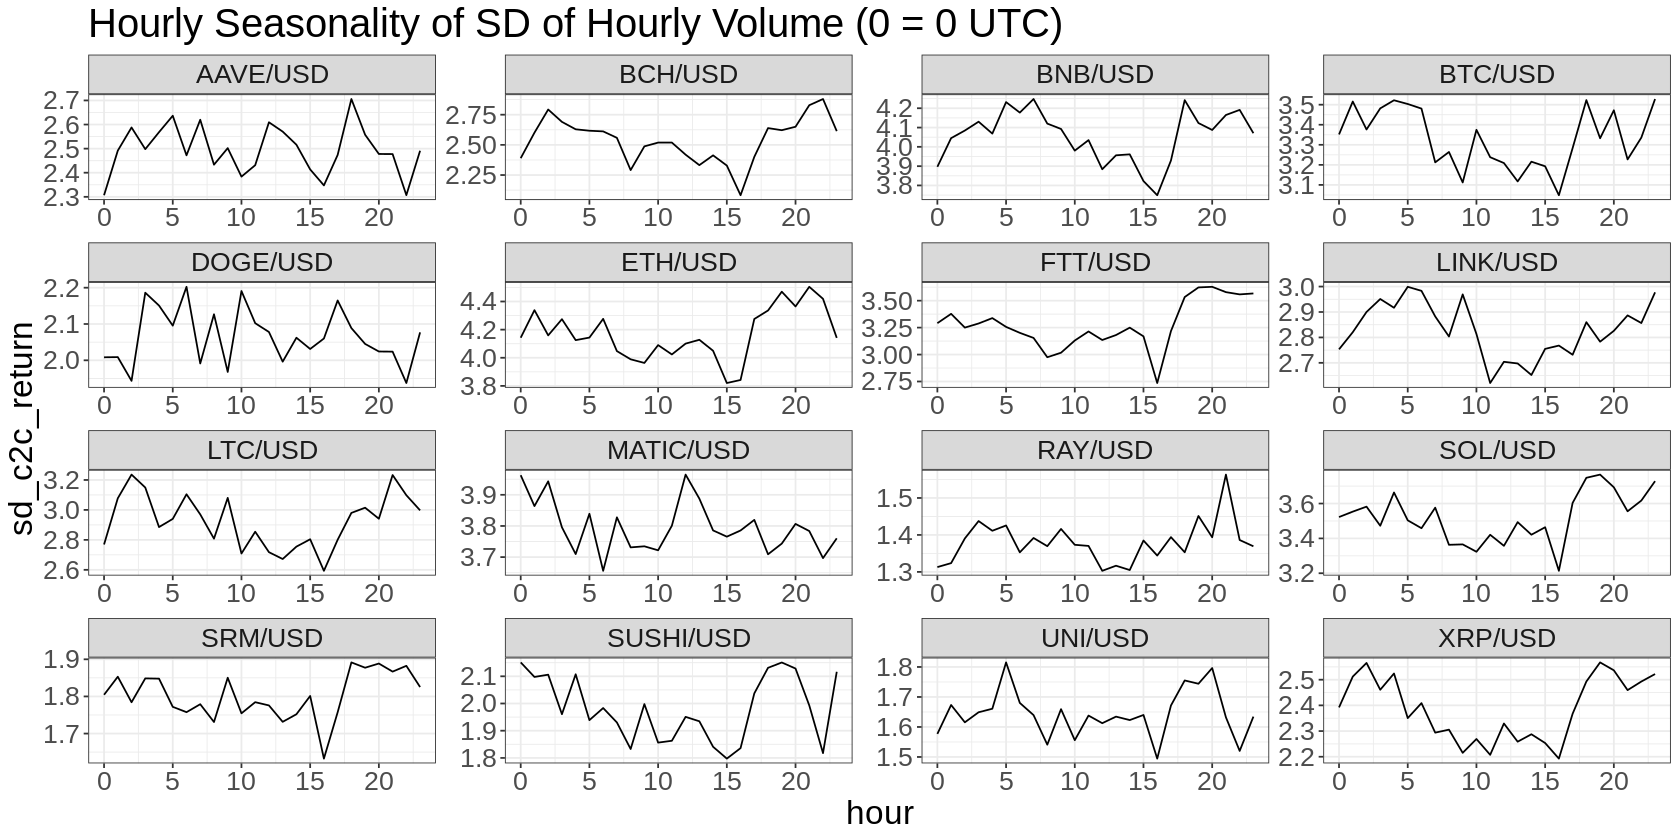

In [11]:
hourly_seasonality %>%
  filter(ticker %in% universe) %>%
  group_by(ticker, hour) %>%
  summarise(sd_c2c_return = sd((logvolume))) %>%
  ggplot(aes(x=hour, y=sd_c2c_return)) +
  geom_line() +
  ggtitle('Hourly Seasonality of SD of Hourly Volume (0 = 0 UTC)') +
  facet_wrap(~ticker, scales='free')


`summarise()` has grouped output by 'ticker'. You can override using the
`.groups` argument.


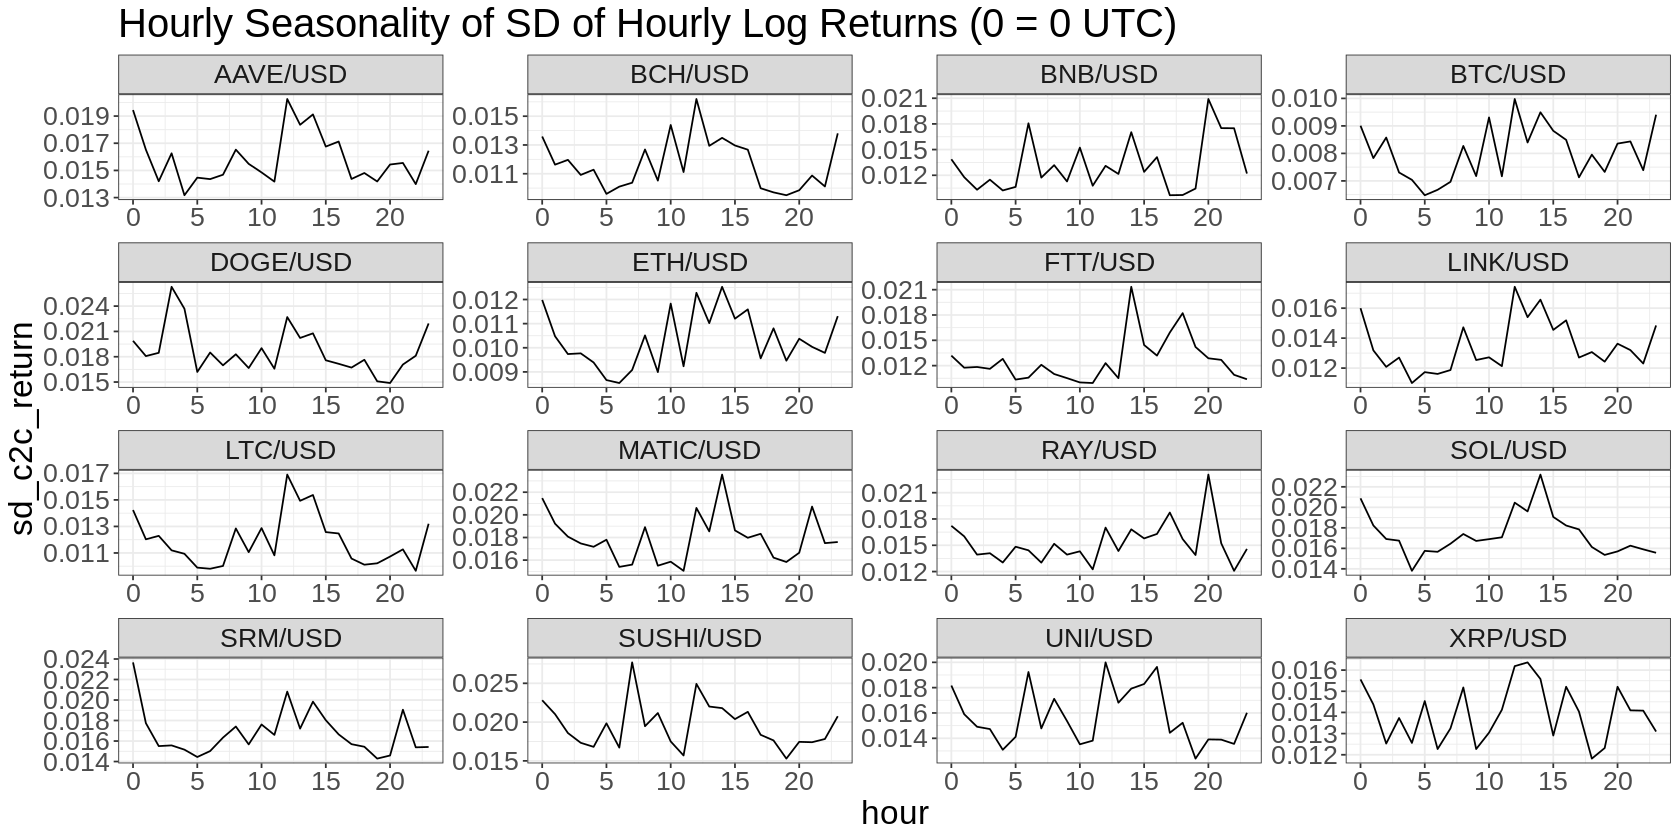

In [12]:
hourly_seasonality %>%
  filter(ticker %in% universe) %>%
  group_by(ticker, hour) %>%
  summarise(sd_c2c_return = sd(c2c_logreturn)) %>%
  ggplot(aes(x=hour, y=sd_c2c_return)) +
  geom_line() +
  ggtitle('Hourly Seasonality of SD of Hourly Log Returns (0 = 0 UTC)') +
  facet_wrap(~ticker, scales='free')


`summarise()` has grouped output by 'ticker'. You can override using the
`.groups` argument.


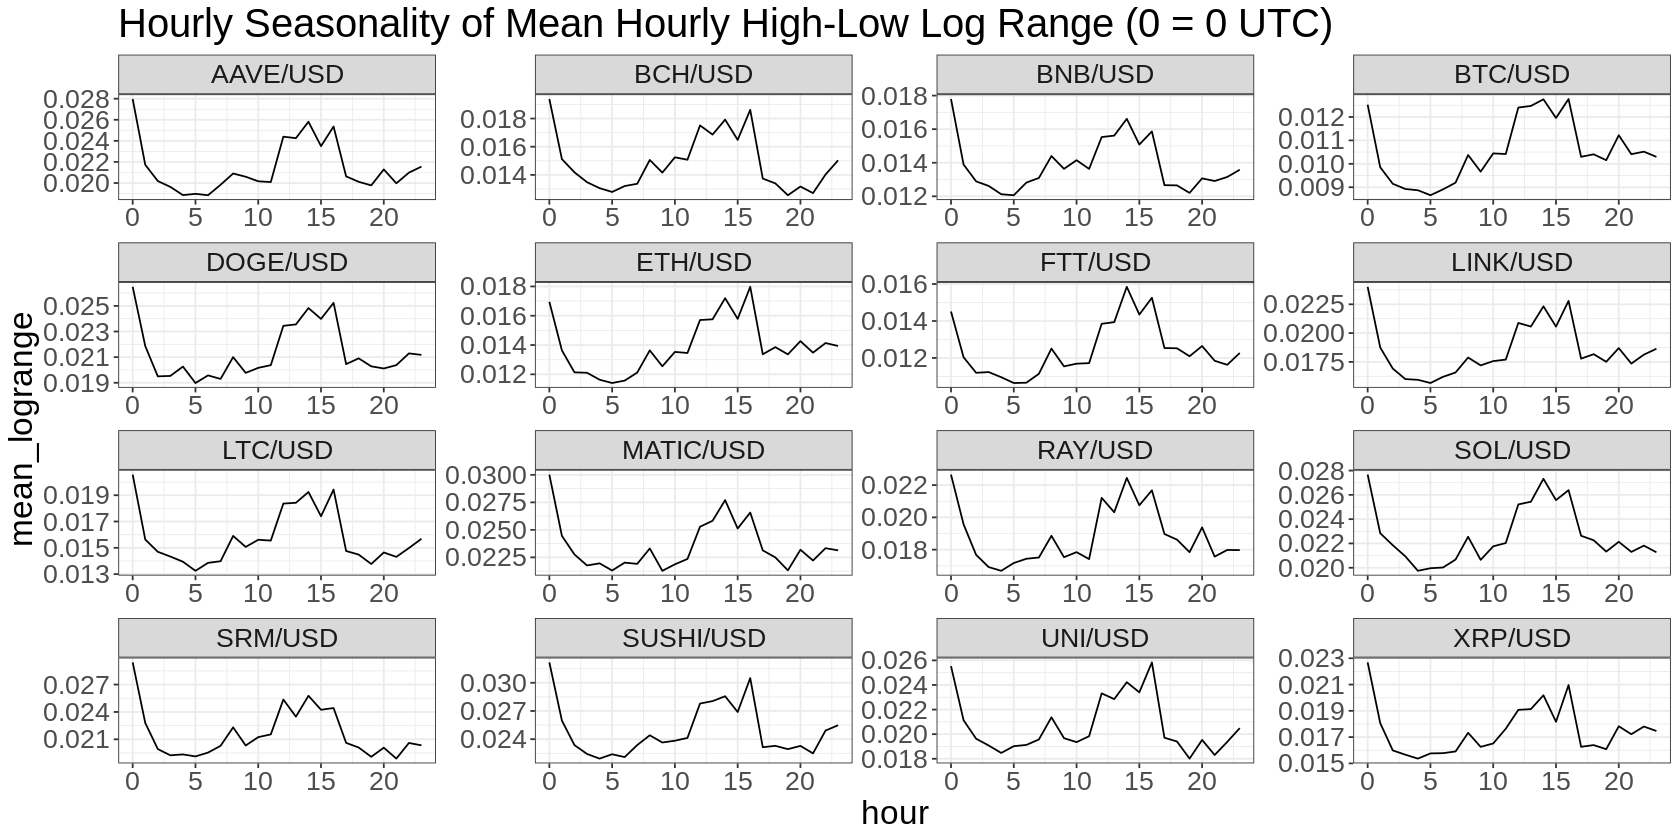

In [13]:
hourly_seasonality %>%
  filter(ticker %in% universe) %>%
  group_by(ticker, hour) %>%
  summarise(mean_logrange = mean(logrange)) %>%
  ggplot(aes(x=hour, y=mean_logrange)) +
  geom_line() +
  ggtitle('Hourly Seasonality of Mean Hourly High-Low Log Range (0 = 0 UTC)') +
  facet_wrap(~ticker, scales='free')

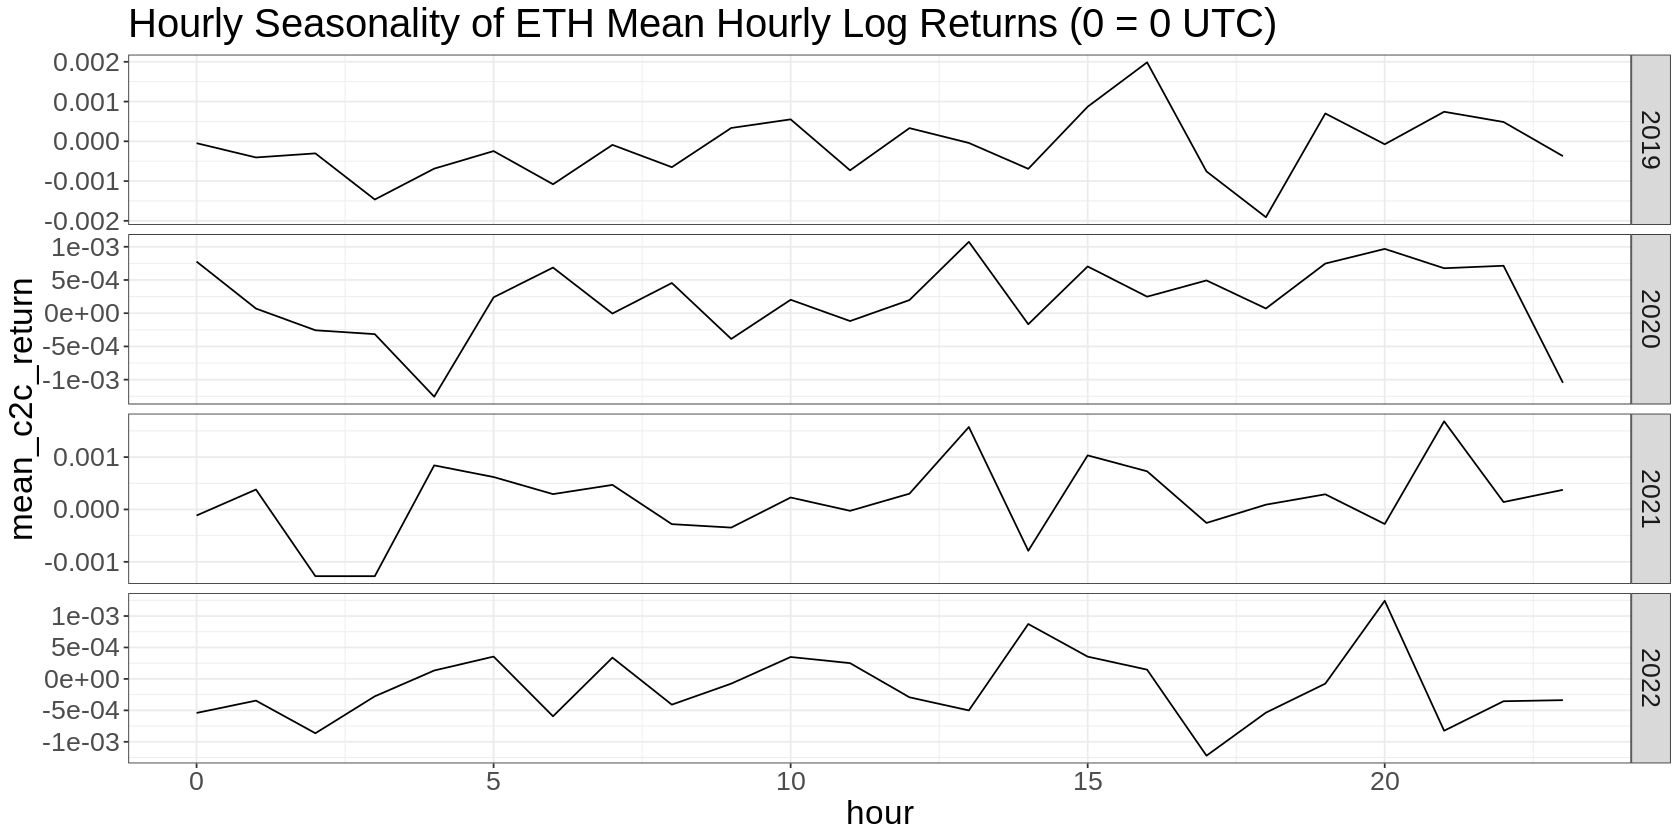

In [14]:
hourly_seasonality %>%
  filter(ticker == 'ETH/USD') %>%
  group_by(ticker, year, hour) %>%
  mutate(mean_c2c_return = mean(c2c_logreturn)) %>%
  ggplot(aes(x=hour, y=mean_c2c_return)) +
  geom_line() +
  ggtitle('Hourly Seasonality of ETH Mean Hourly Log Returns (0 = 0 UTC)') +
  facet_grid(rows= vars(year), scales='free')

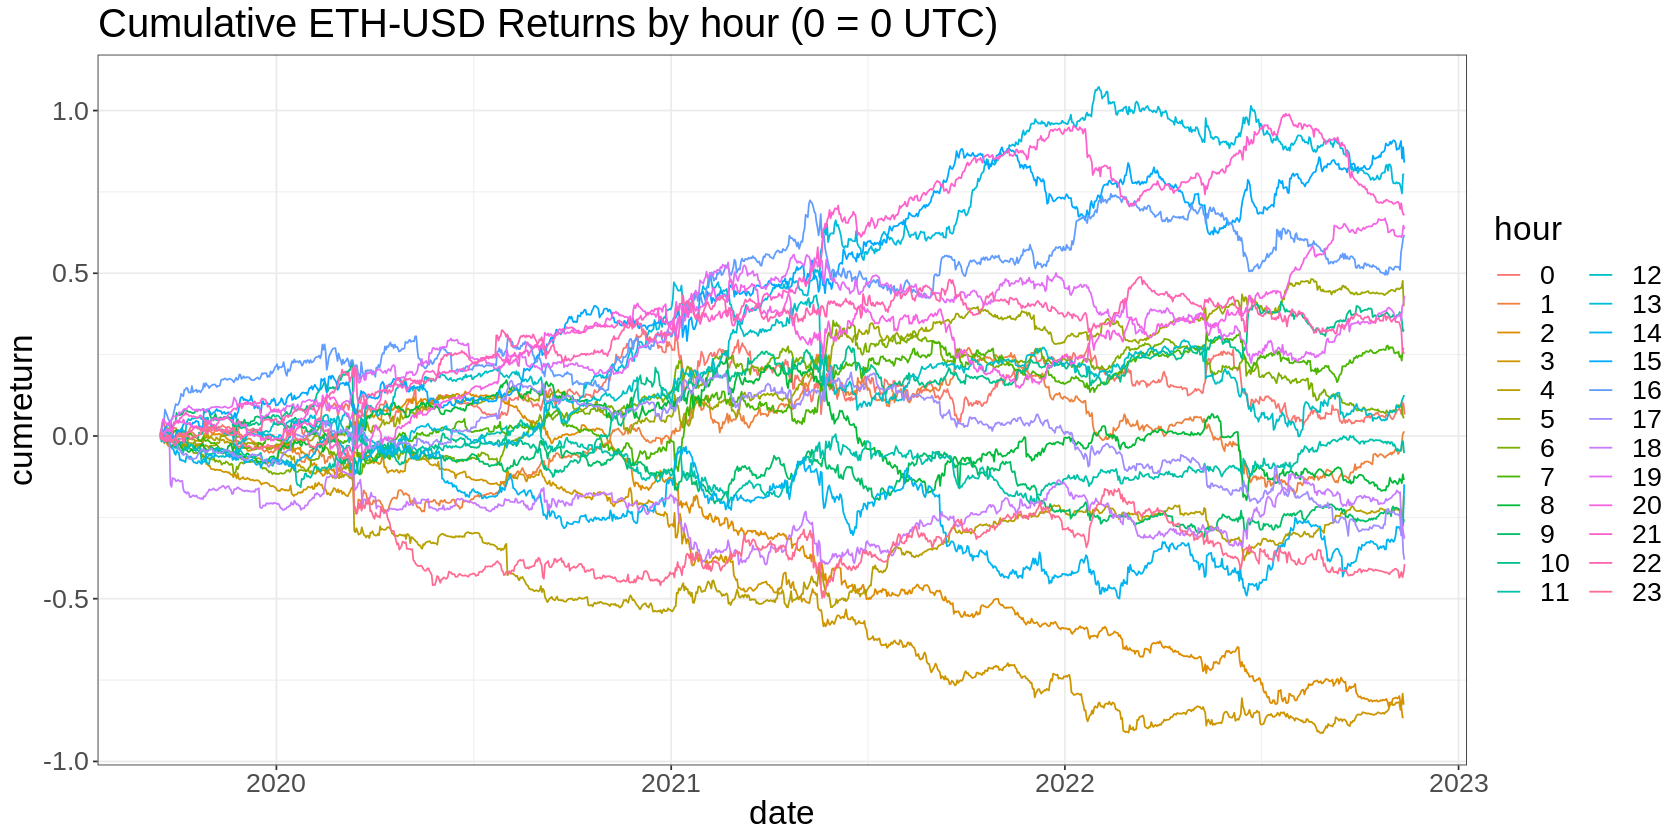

In [15]:
spot %>%
  filter(ticker == 'ETH/USD') %>%
  arrange(date) %>%
  mutate(
    hour = factor(lubridate::hour(date)), 
    c2c_logreturn = log(close/lag(close)),
  ) %>%
  na.omit() %>%
  group_by(hour) %>%
  mutate(cumreturn = cumsum(c2c_logreturn)) %>%
  ggplot(aes(x=date, y=cumreturn, color=hour)) + 
    geom_line() +
    ggtitle('Cumulative ETH-USD Returns by hour (0 = 0 UTC)')

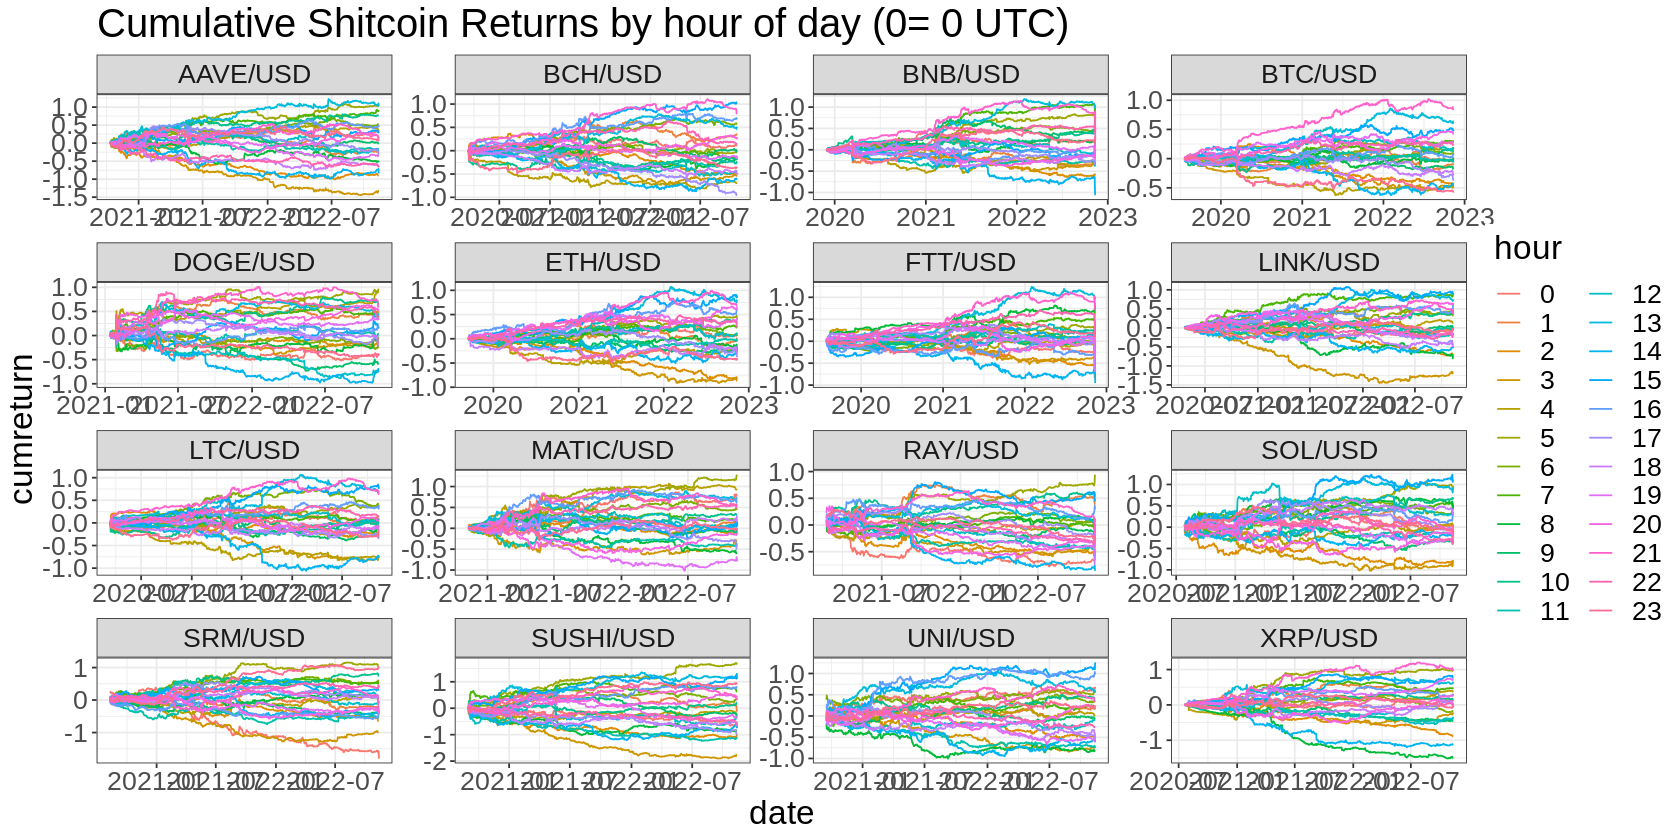

In [16]:
spot %>%
  filter(ticker %in% universe) %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(
    hour = factor(lubridate::hour(date)), 
    c2c_logreturn = log(close/lag(close)),
  ) %>%
  na.omit() %>%
  group_by(ticker, hour) %>%
  mutate(cumreturn = cumsum(c2c_logreturn)) %>%
  ggplot(aes(x=date, y=cumreturn, color=hour)) + 
    geom_line() +
    ggtitle('Cumulative Shitcoin Returns by hour of day (0= 0 UTC)') +
    facet_wrap(~ticker, scales = 'free')

# Dumb Hour of Day Strategy - Ape Long BTC and ETH 18,19,20,21

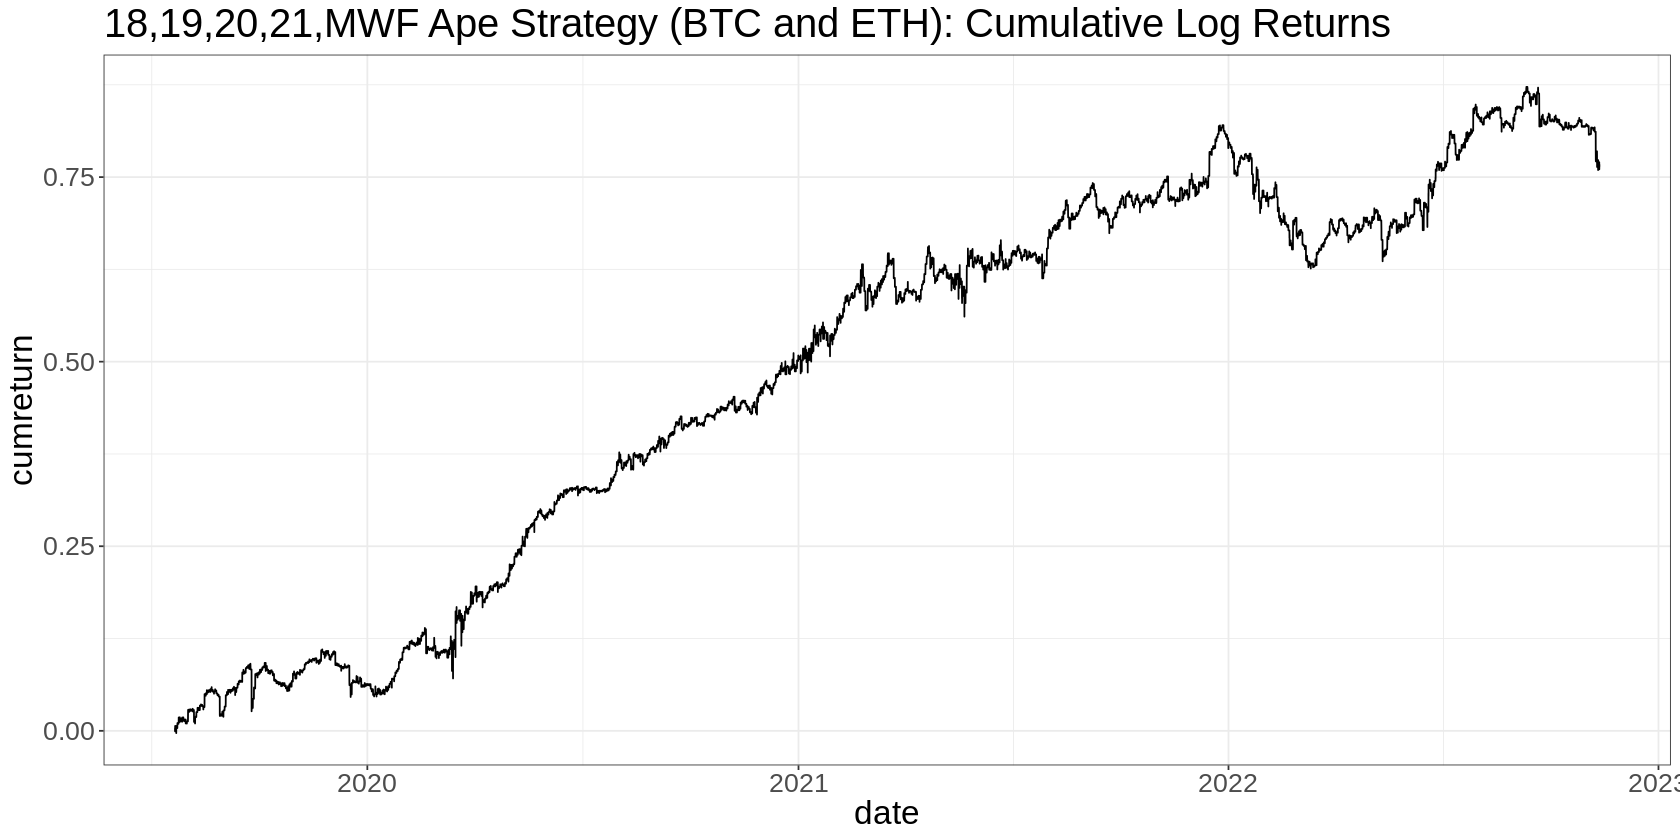

In [17]:
spot %>%
  filter(ticker %in% c('BTC/USD','ETH/USD')) %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(
    hour = factor(lubridate::hour(date)),
    dayofweek = factor(lubridate::wday(date)), 
    c2c_simplereturn = close / lag(close) - 1,
    c2c_logreturn = log(close/lag(close)),
  ) %>%
  na.omit() %>%
  mutate(strat_return = case_when(hour %in% c(18,19,20,21) ~ c2c_simplereturn, TRUE ~ 0)) %>%
  group_by(date) %>%
  summarise(strat_logreturn = log(mean(strat_return / 2) + 1)) %>%
  arrange(date) %>%
  mutate(cumreturn = cumsum(strat_logreturn)) %>%
  ggplot(aes(x=date, y=cumreturn)) +
    geom_line() +
    ggtitle('18,19,20,21,MWF Ape Strategy (BTC and ETH): Cumulative Log Returns')
  

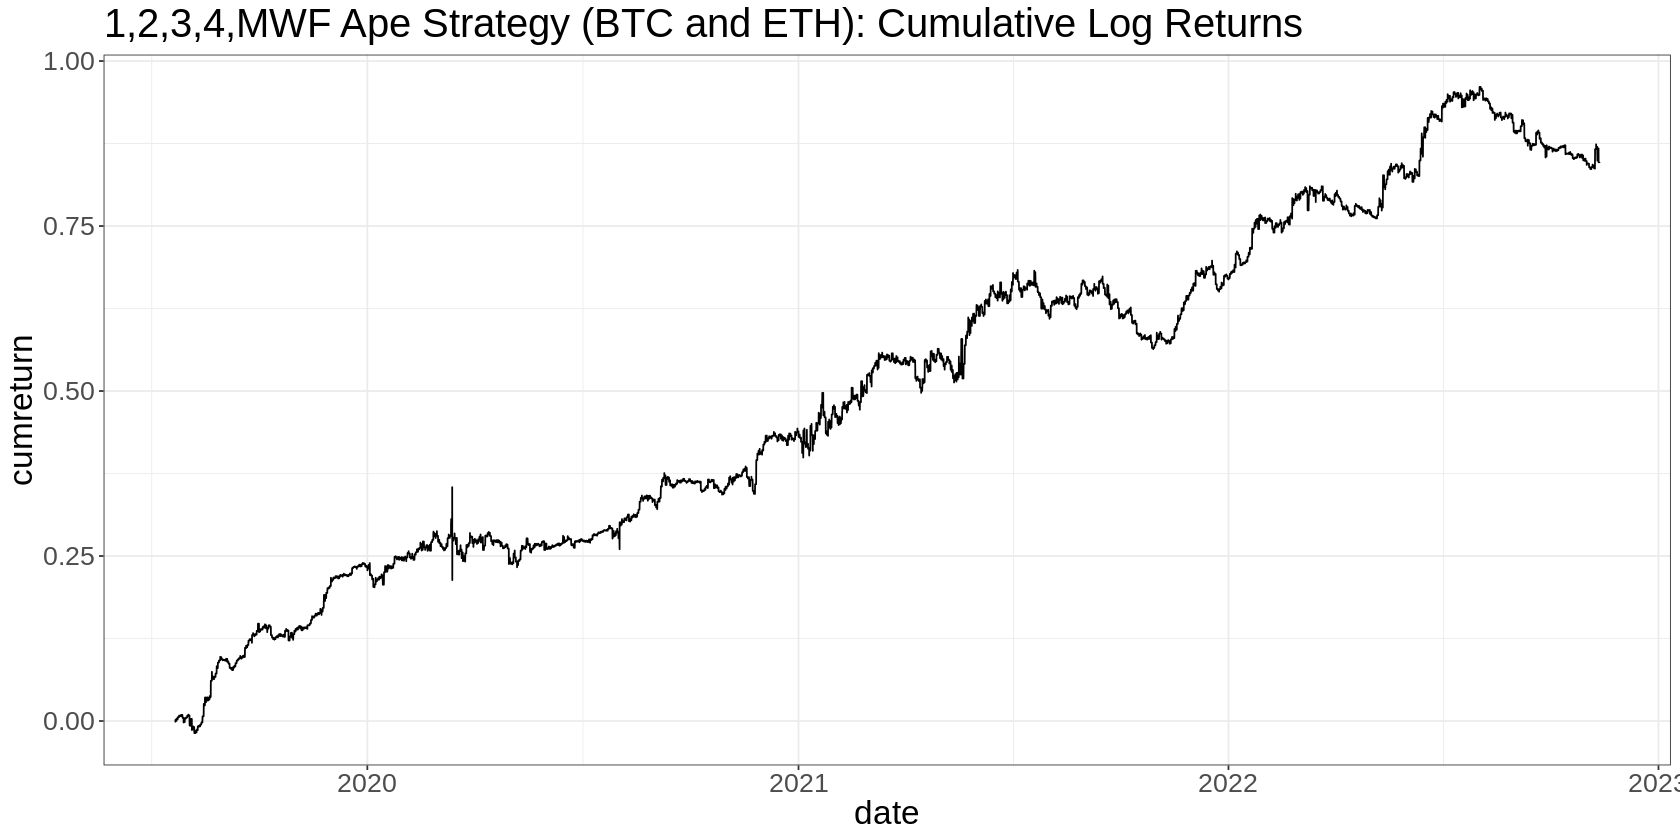

In [18]:
spot %>%
  filter(ticker %in% c('BTC/USD','ETH/USD')) %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(
    hour = factor(lubridate::hour(date)), 
    c2c_simplereturn = close / lag(close) - 1,
    c2c_logreturn = log(close/lag(close)),
  ) %>%
  na.omit() %>%
  mutate(strat_return = case_when(hour %in% c(1,2,3,4) ~ c2c_simplereturn, TRUE ~ 0)) %>%
  group_by(date) %>%
  summarise(strat_logreturn = -log(mean(strat_return / 2) + 1)) %>%
  arrange(date) %>%
  mutate(cumreturn = cumsum(strat_logreturn)) %>%
  ggplot(aes(x=date, y=cumreturn)) +
    geom_line() +
    ggtitle('1,2,3,4,MWF Ape Strategy (BTC and ETH): Cumulative Log Returns')
  

Let's condition on Monday Wednesday Friday

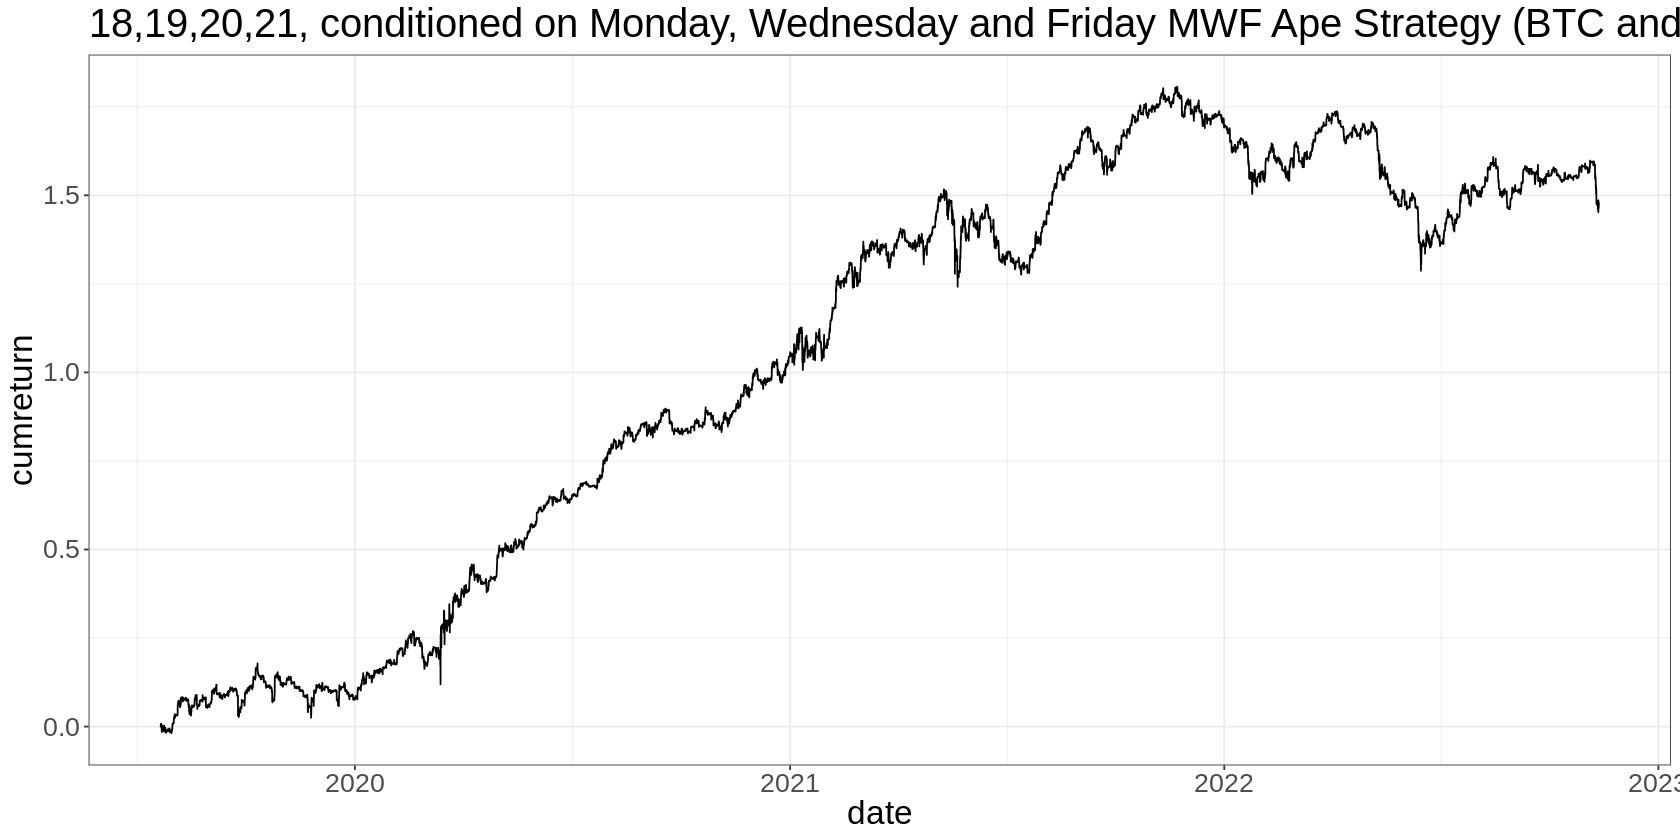

In [19]:
spot %>%
  filter(ticker %in% c('BTC/USD','ETH/USD')) %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(
    hour = factor(lubridate::hour(date)),
    dayofweek = factor(lubridate::wday(date)), 
    c2c_simplereturn = close / lag(close) - 1,
    c2c_logreturn = log(close/lag(close)),
  ) %>%
  na.omit() %>%
  mutate(strat_return = case_when(hour %in% c(18,19,20,21) ~ c2c_simplereturn,dayofweek %in% c(2,4,6) ~ c2c_simplereturn, TRUE ~ 0)) %>%
  group_by(date) %>%
  summarise(strat_logreturn = log(mean(strat_return / 2) + 1)) %>%
  arrange(date) %>%
  mutate(cumreturn = cumsum(strat_logreturn)) %>%
  ggplot(aes(x=date, y=cumreturn)) +
    geom_line() +
    ggtitle('18,19,20,21, conditioned on Monday, Wednesday and Friday MWF Ape Strategy (BTC and ETH): Cumulative Log Returns')
  

#Seasonality Analysis autocorrelation

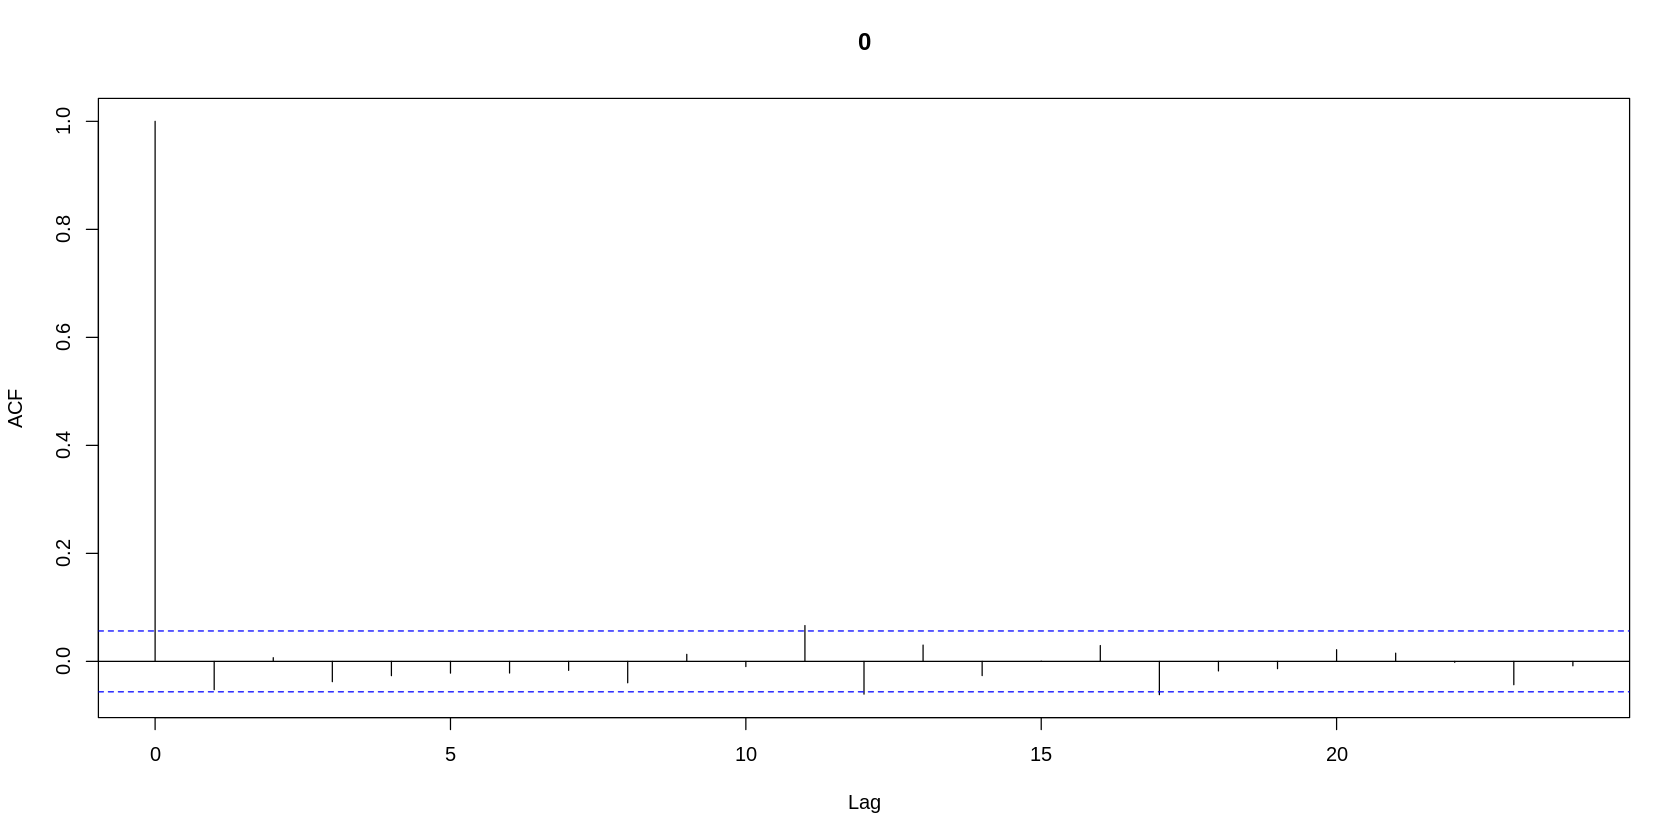

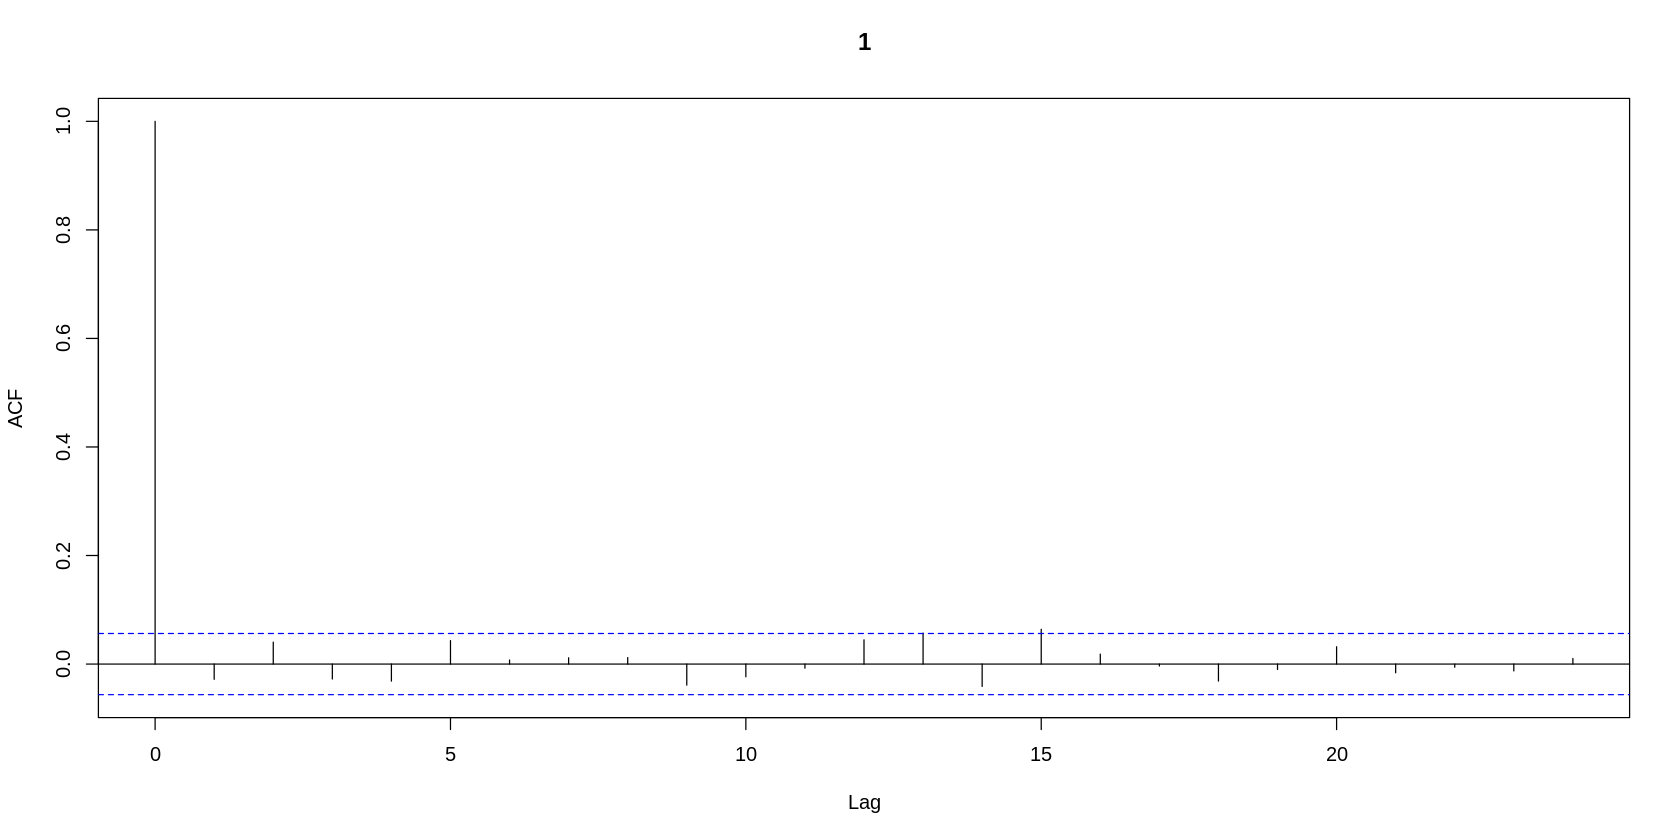

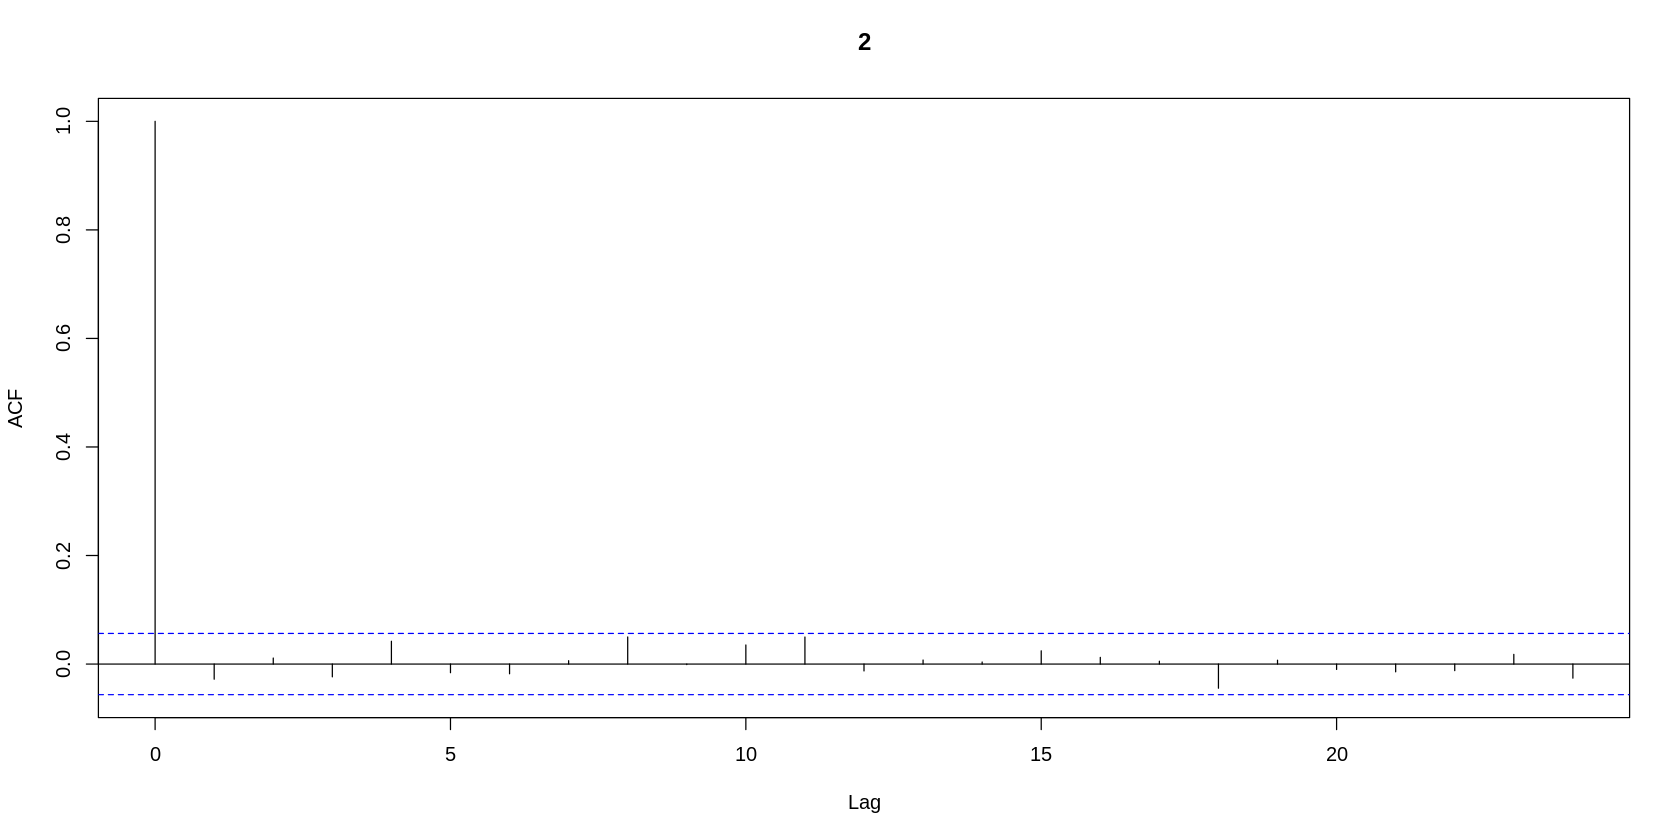

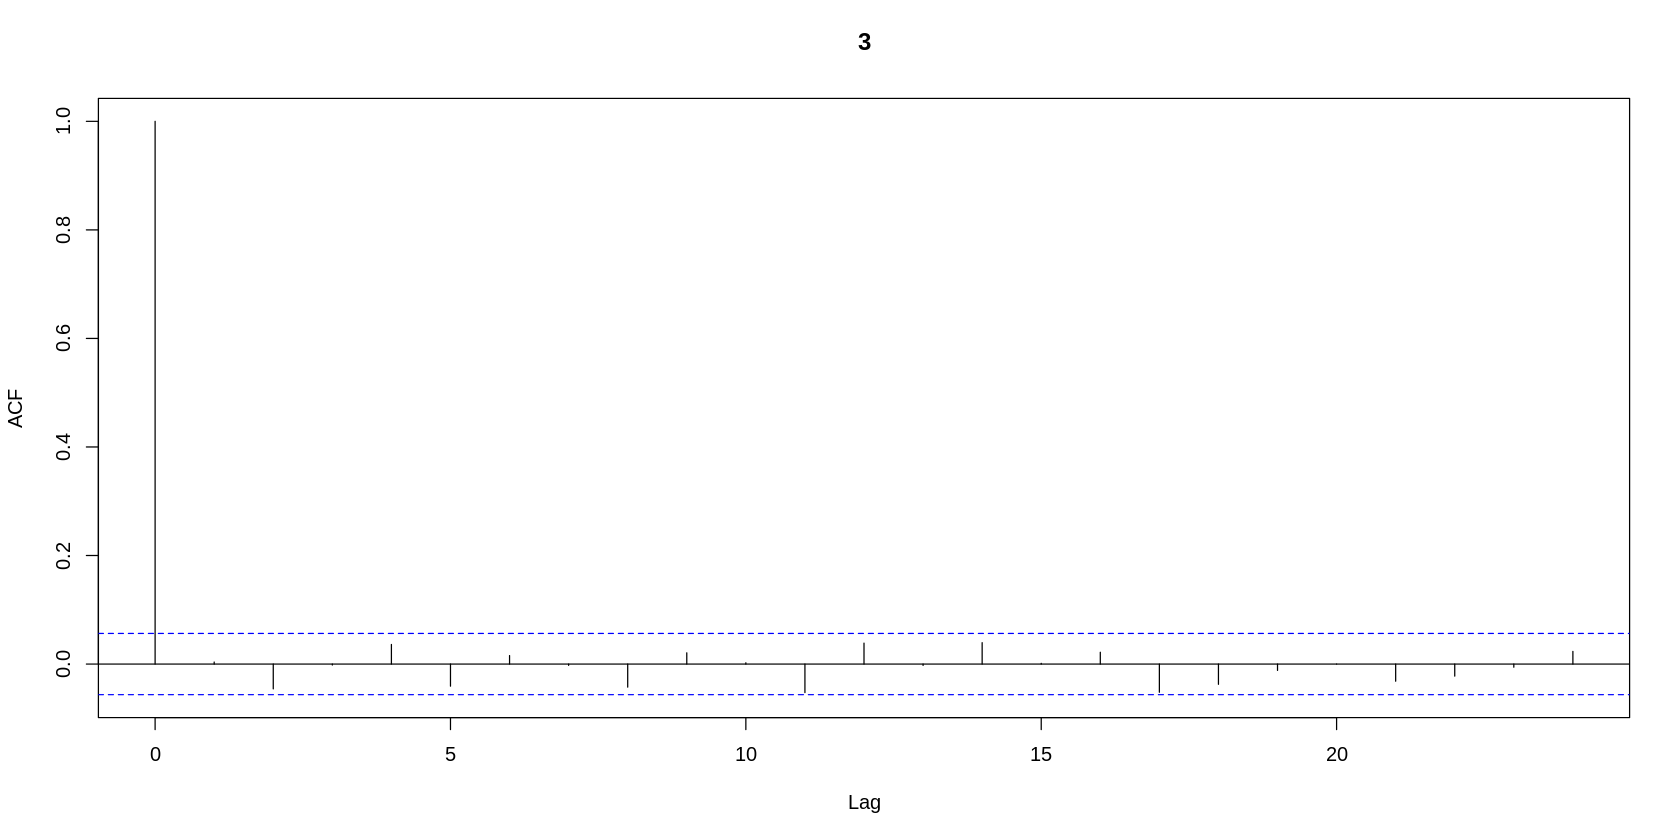

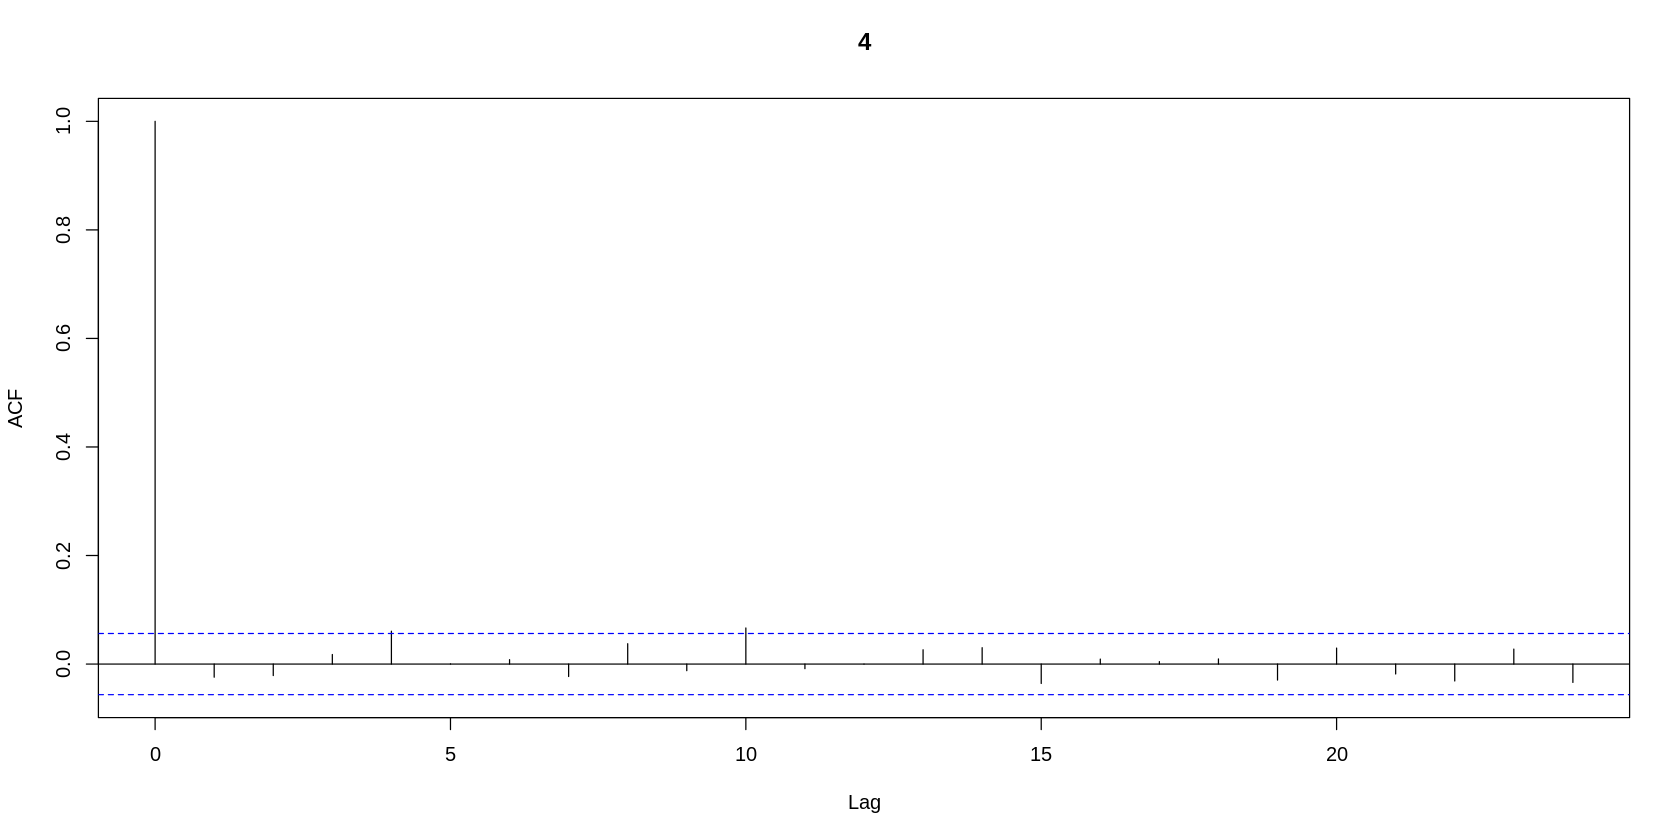

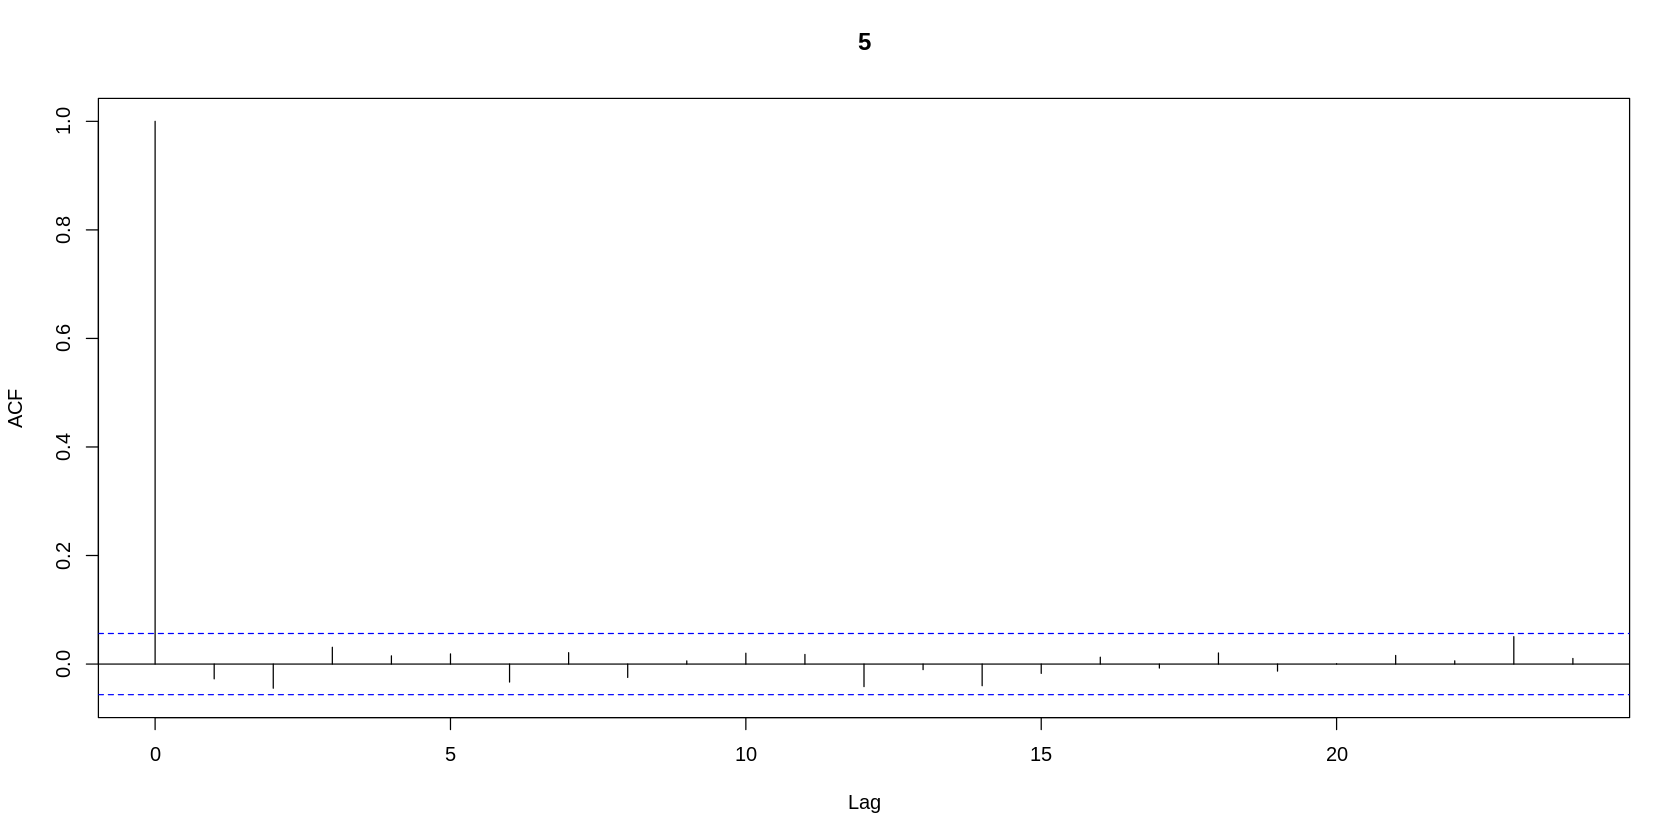

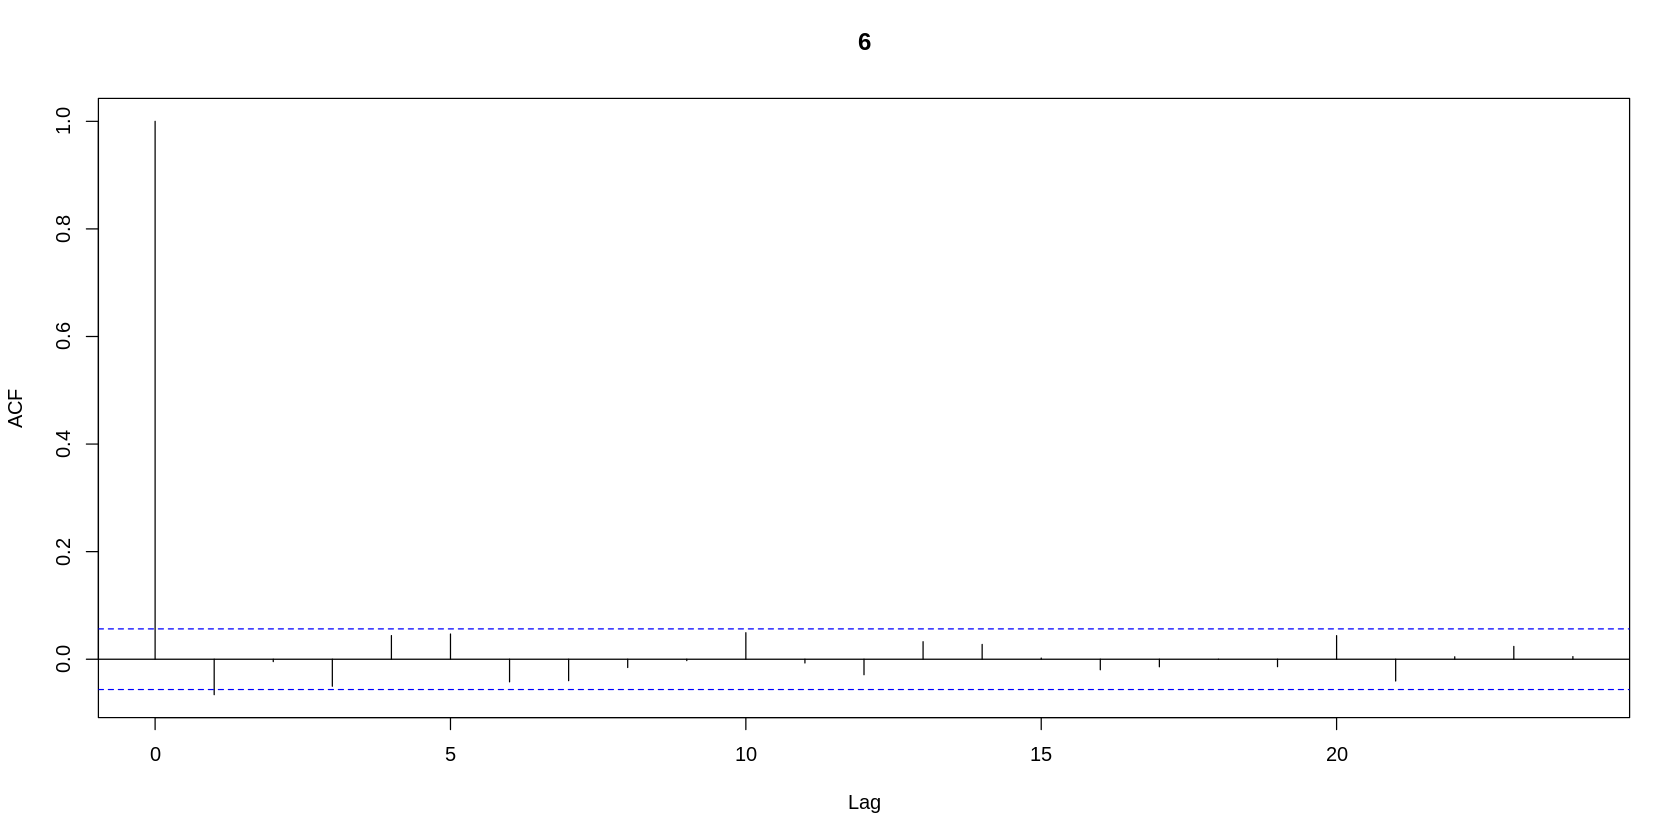

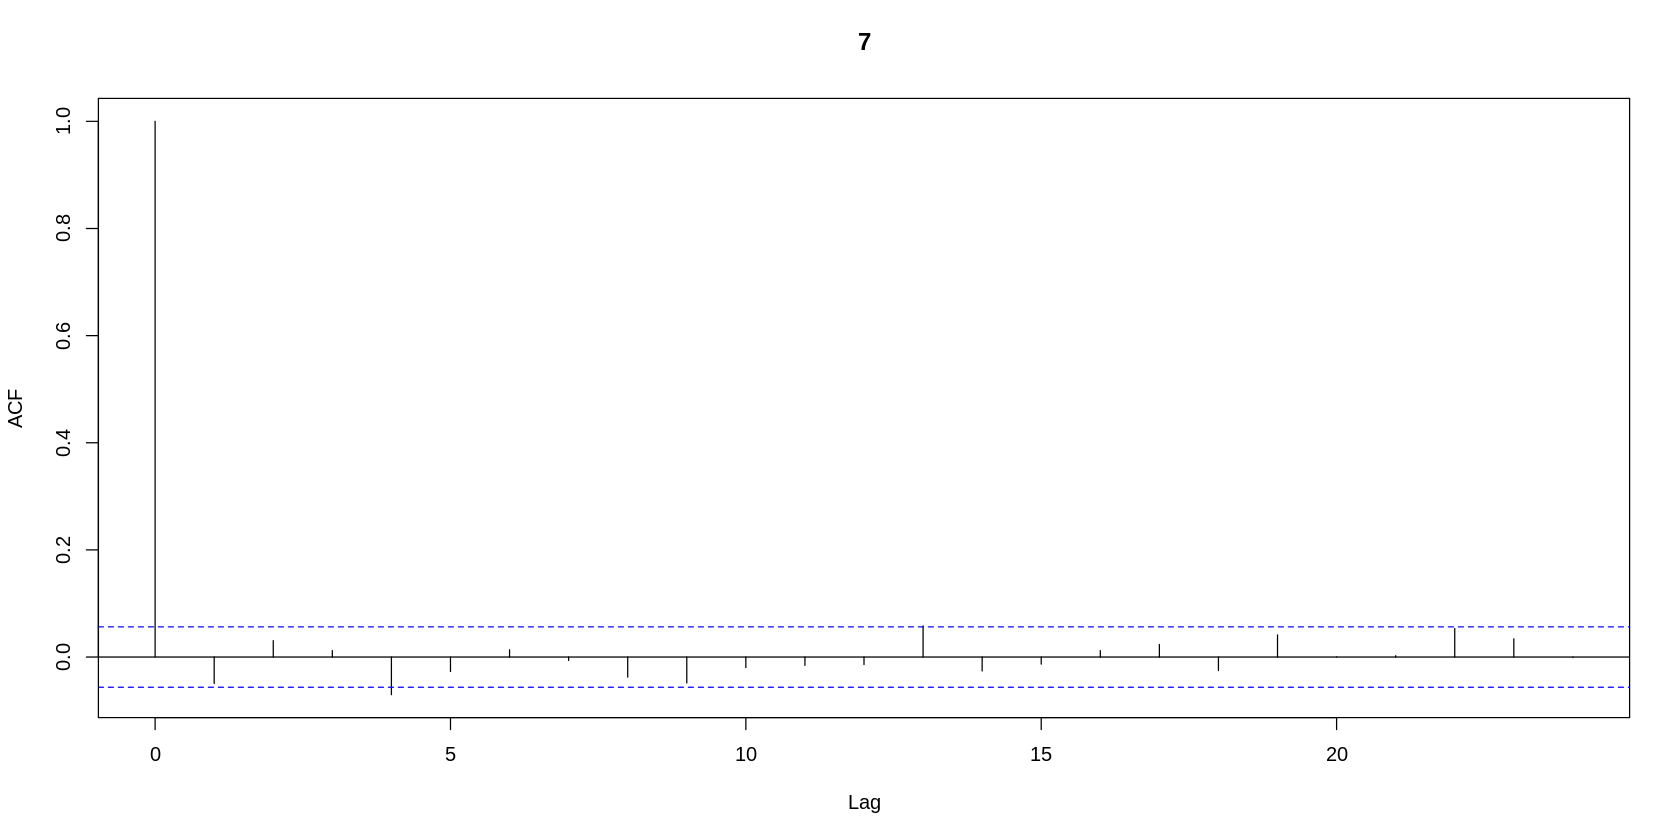

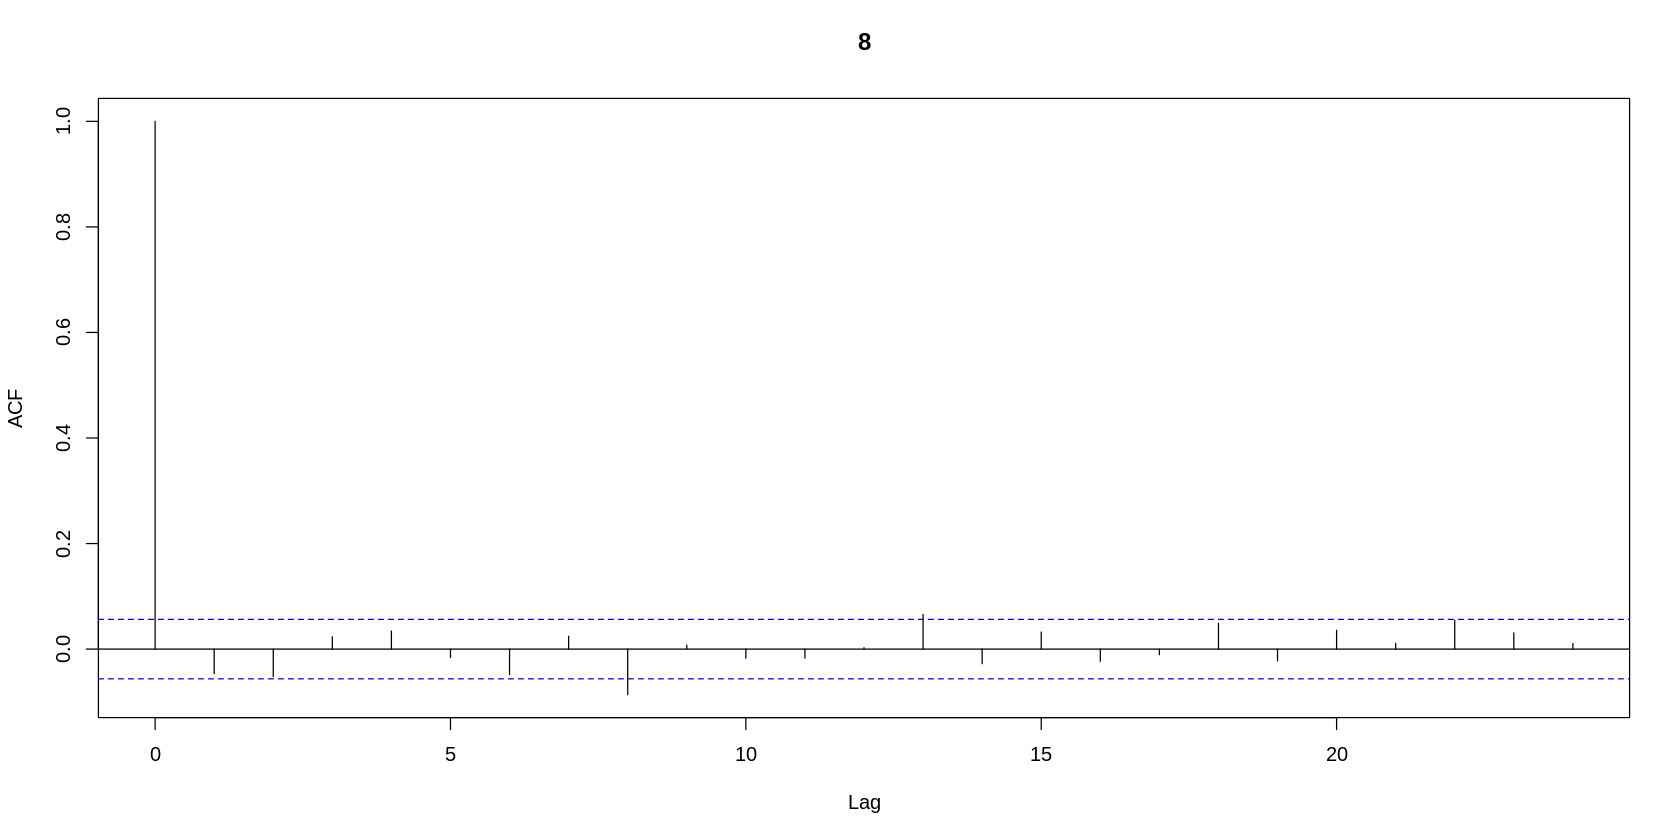

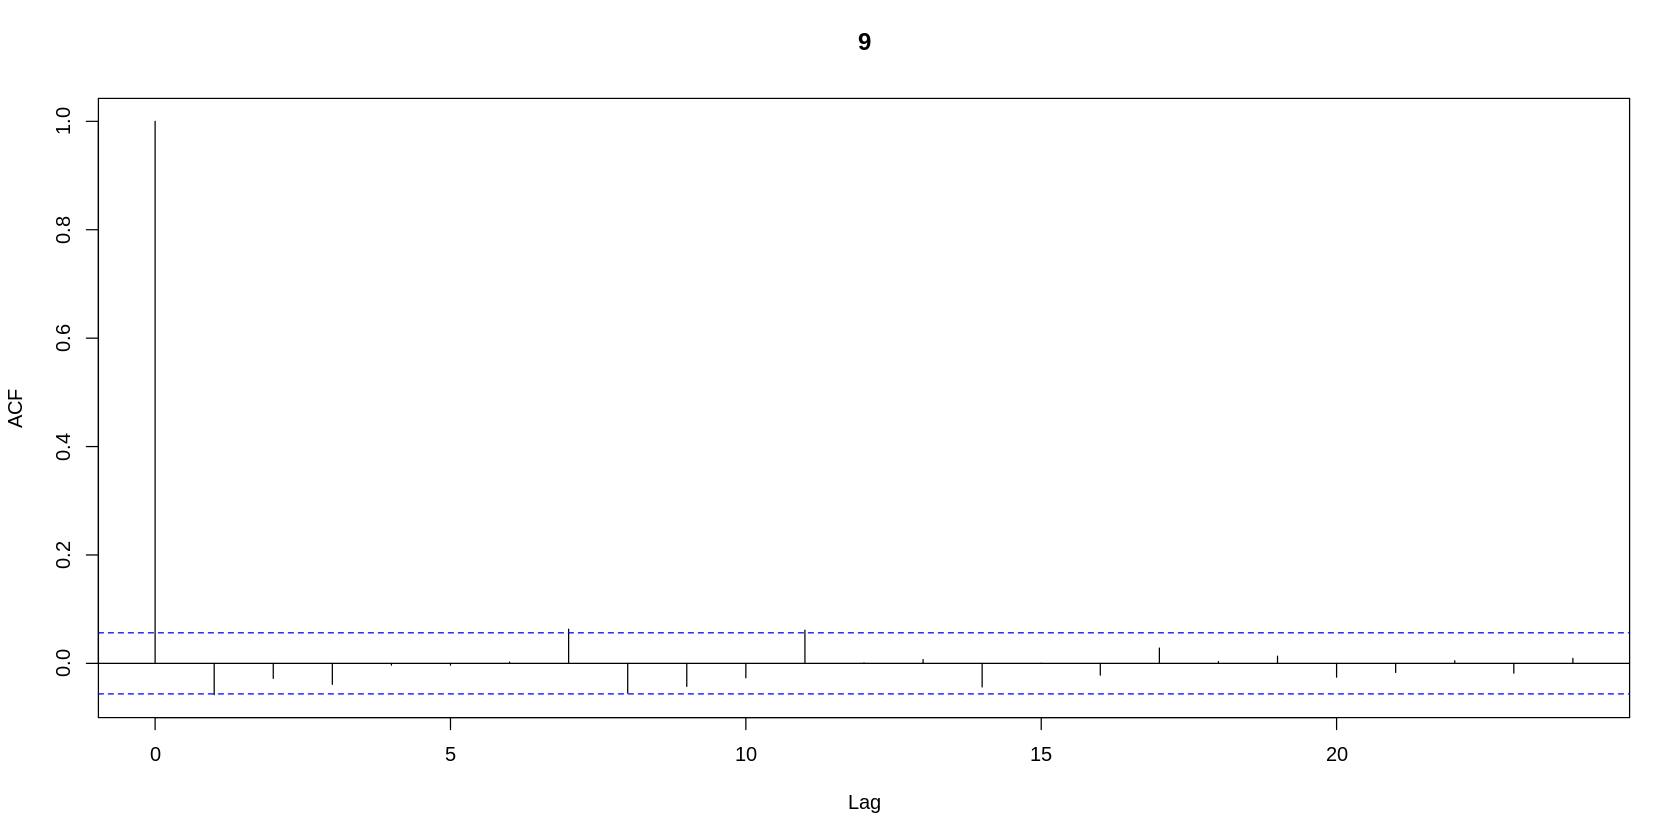

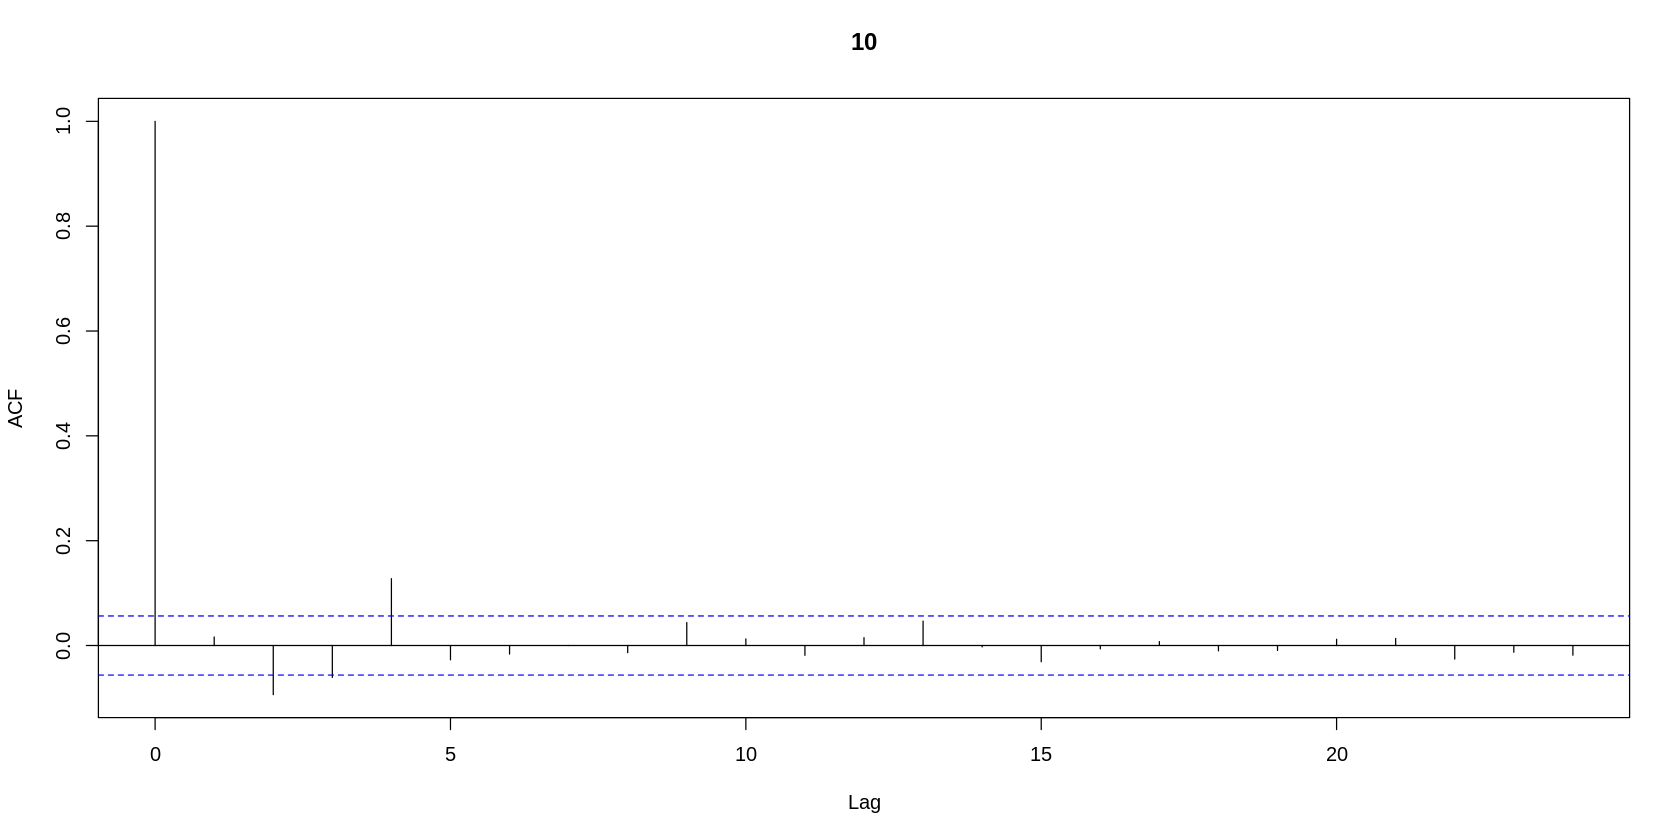

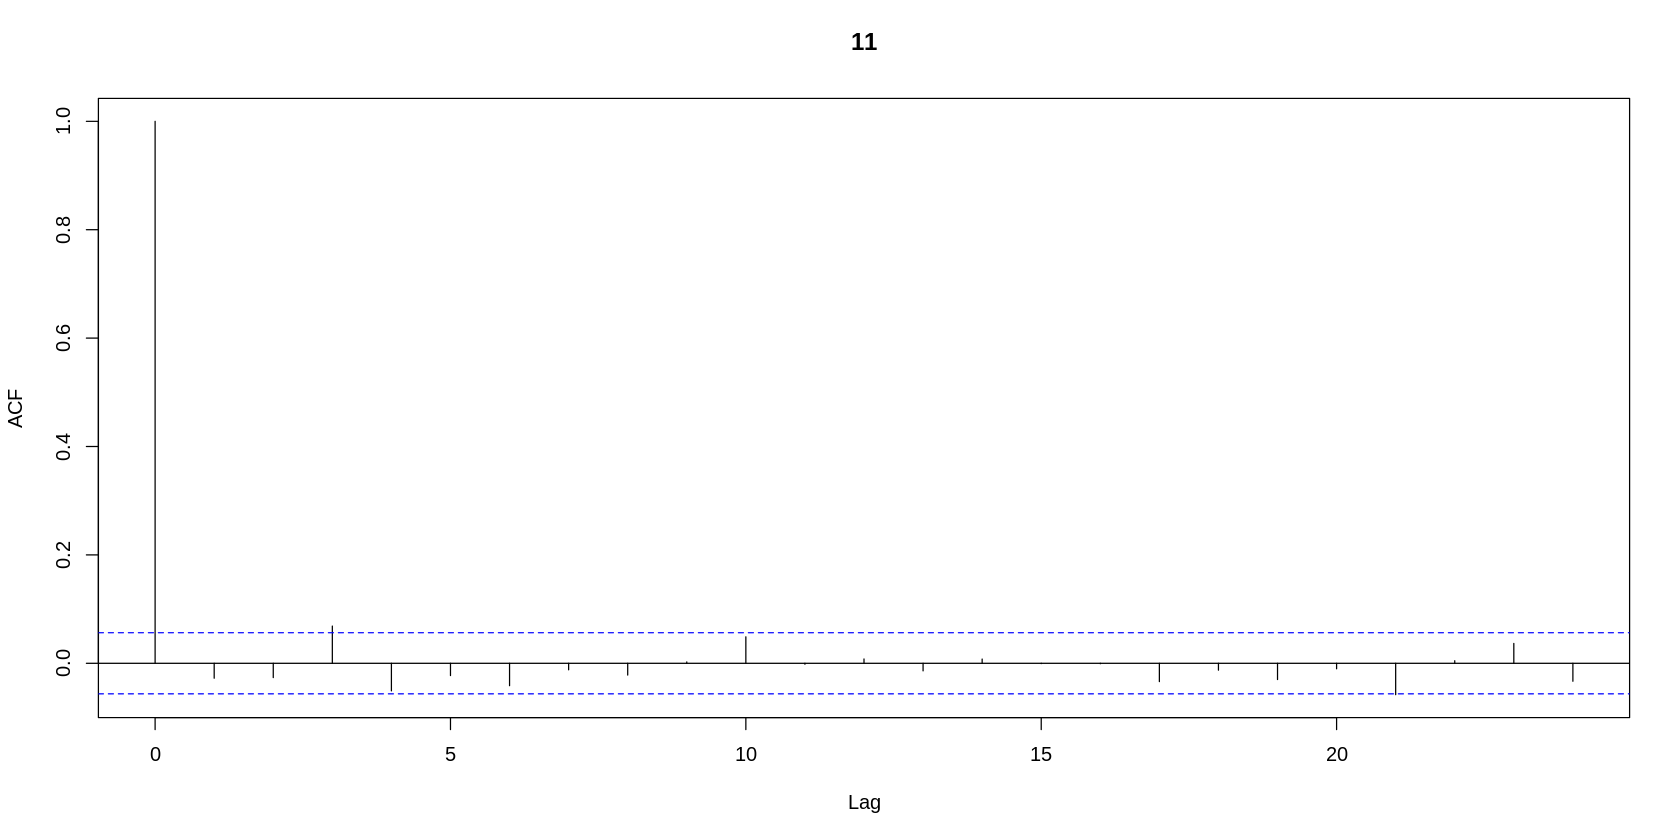

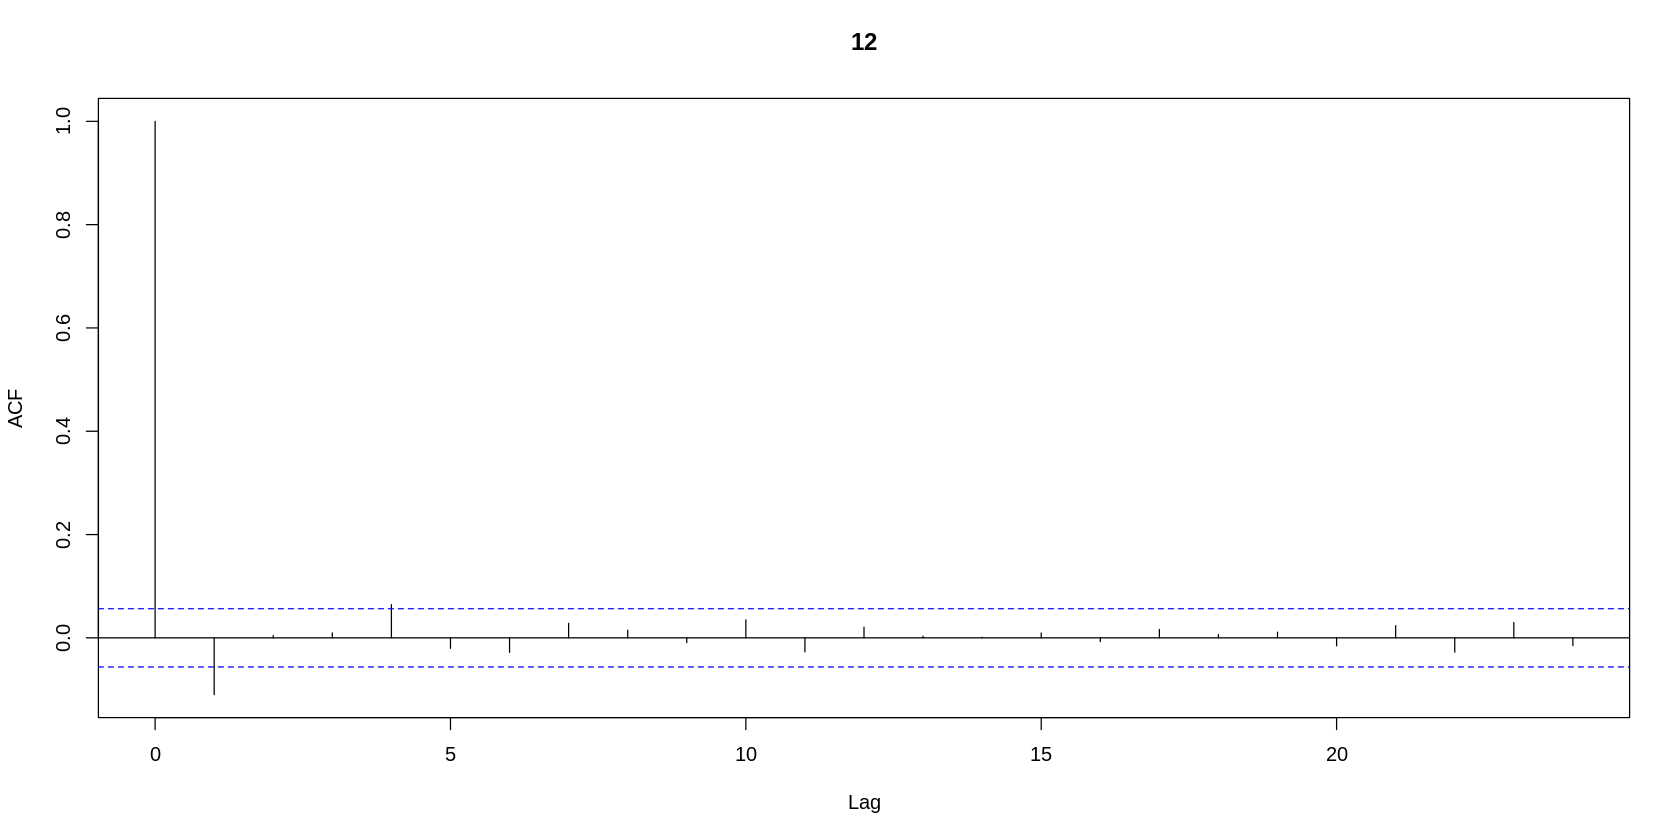

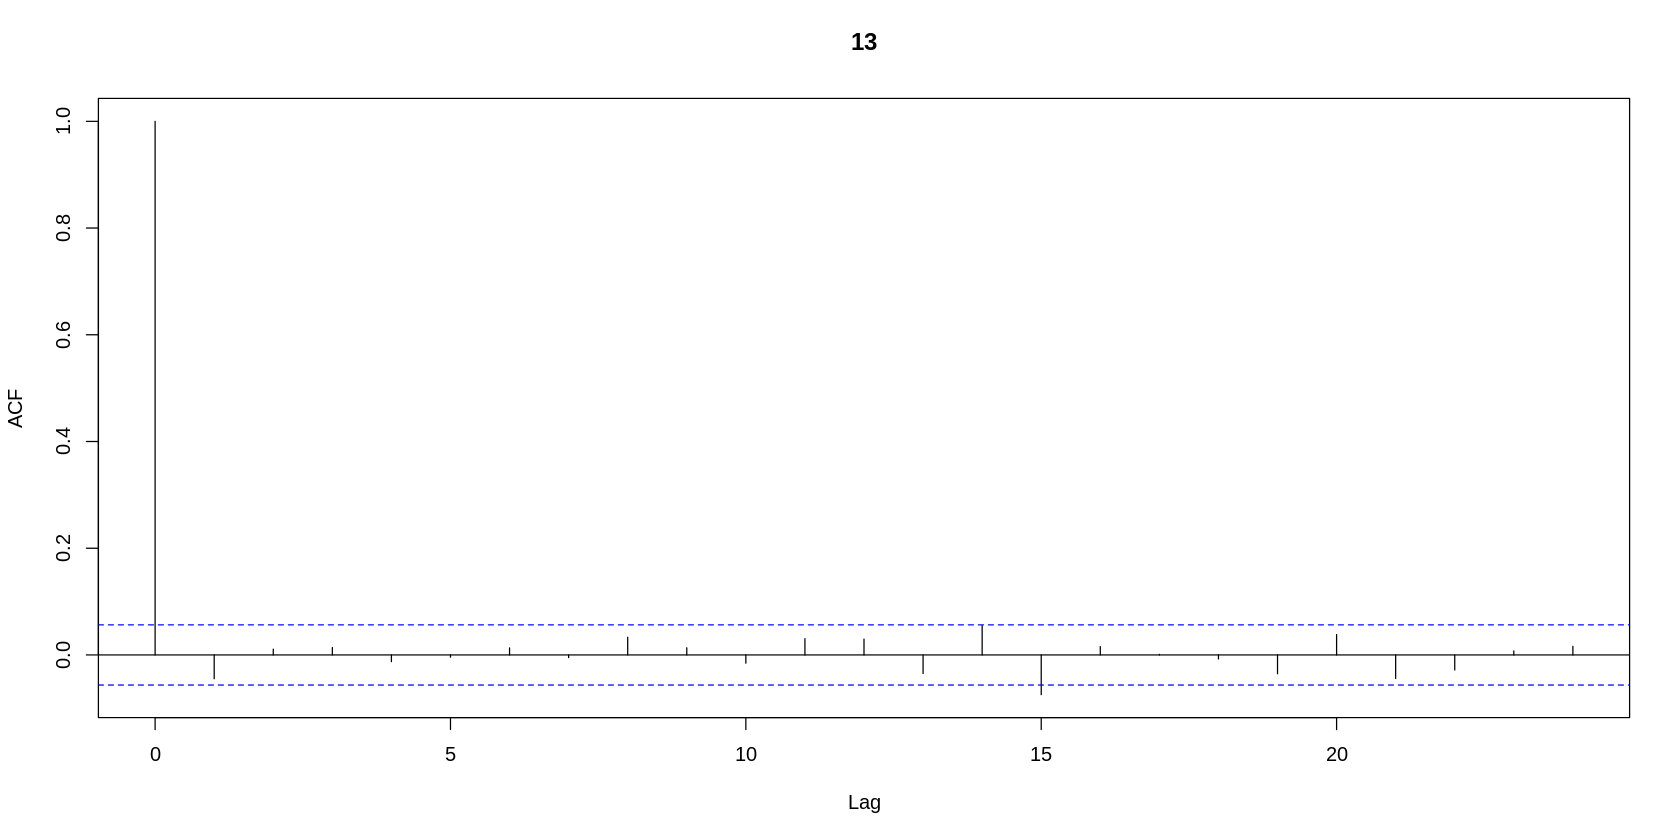

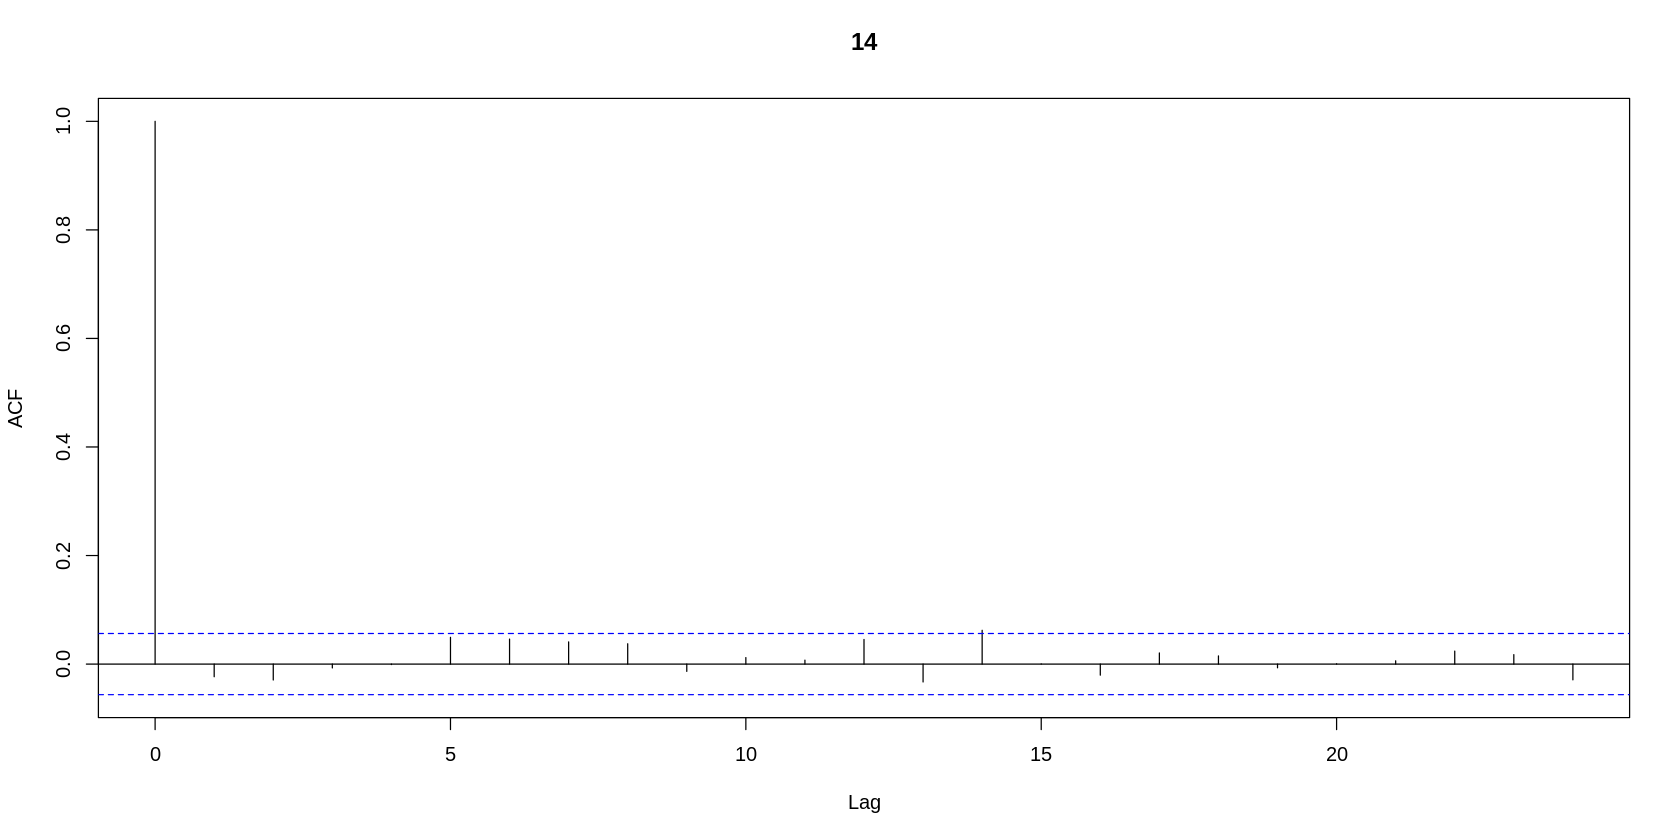

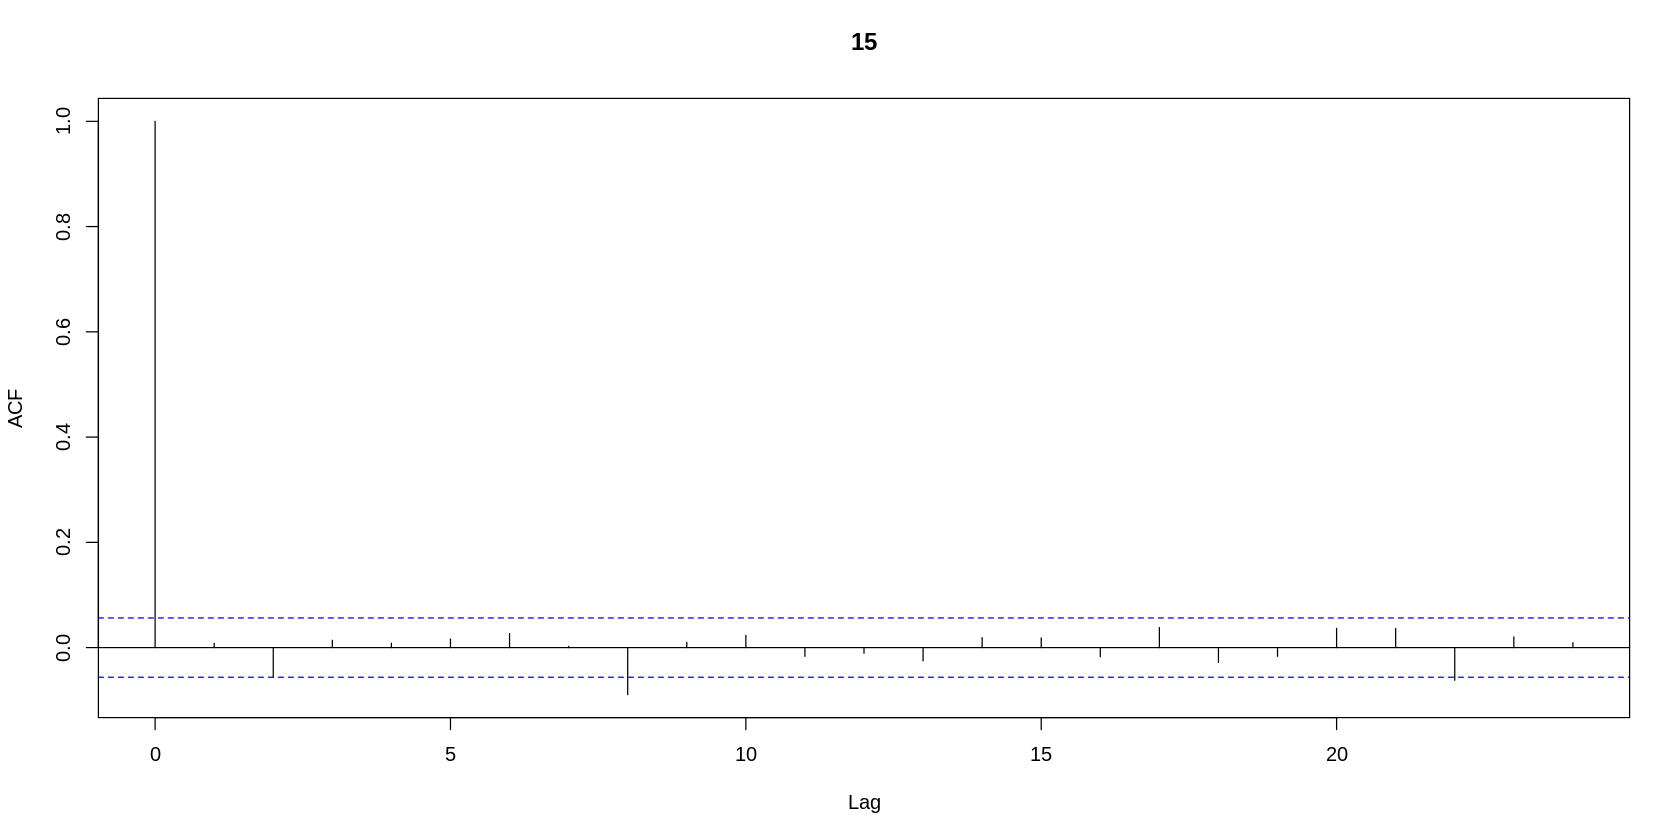

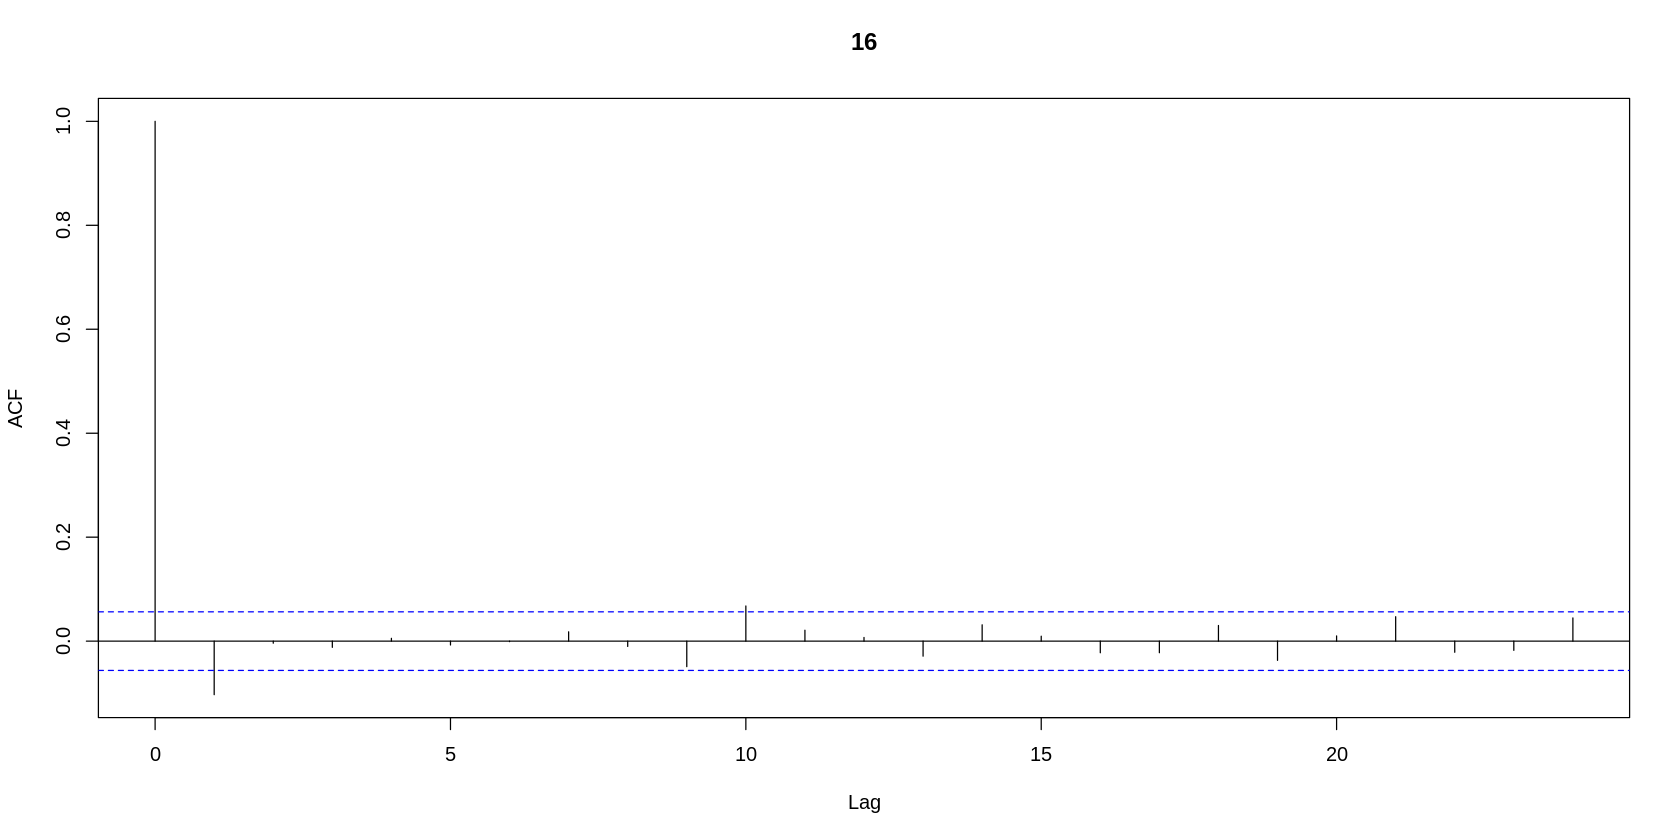

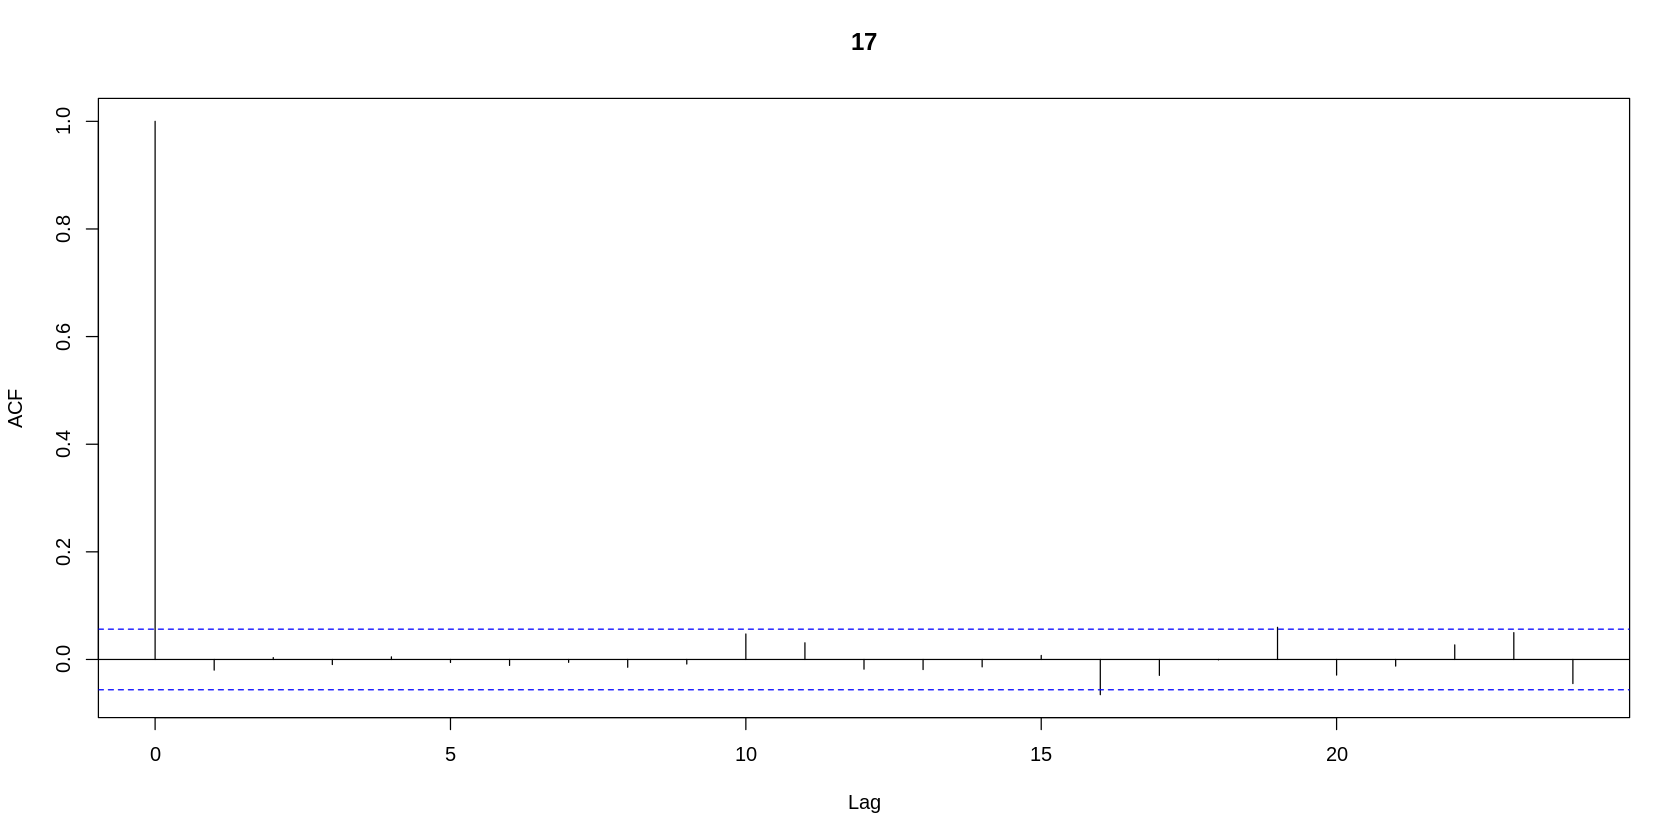

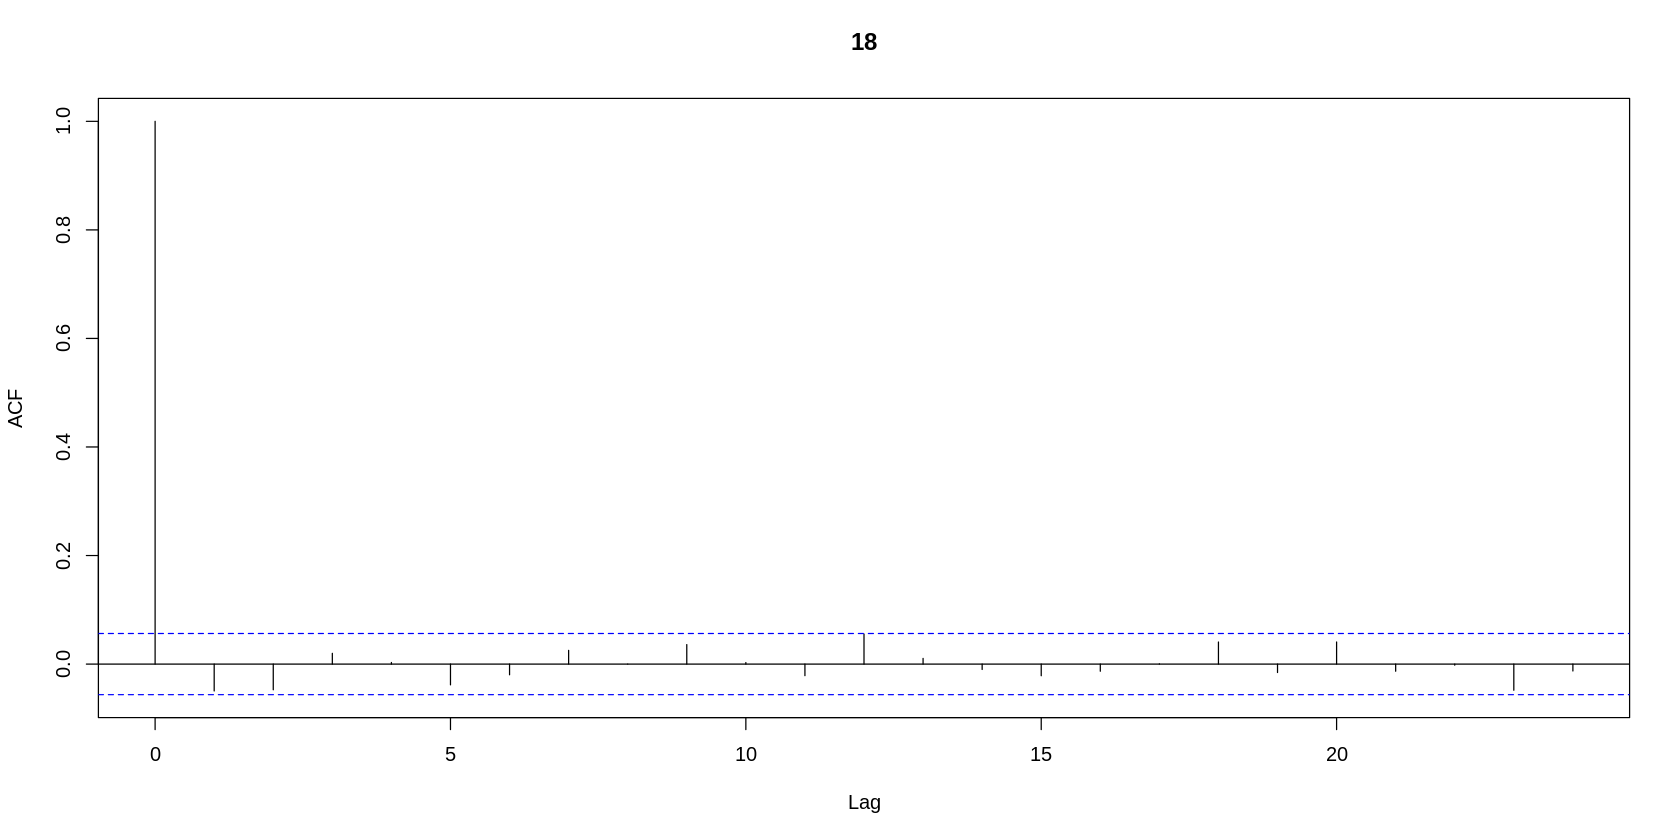

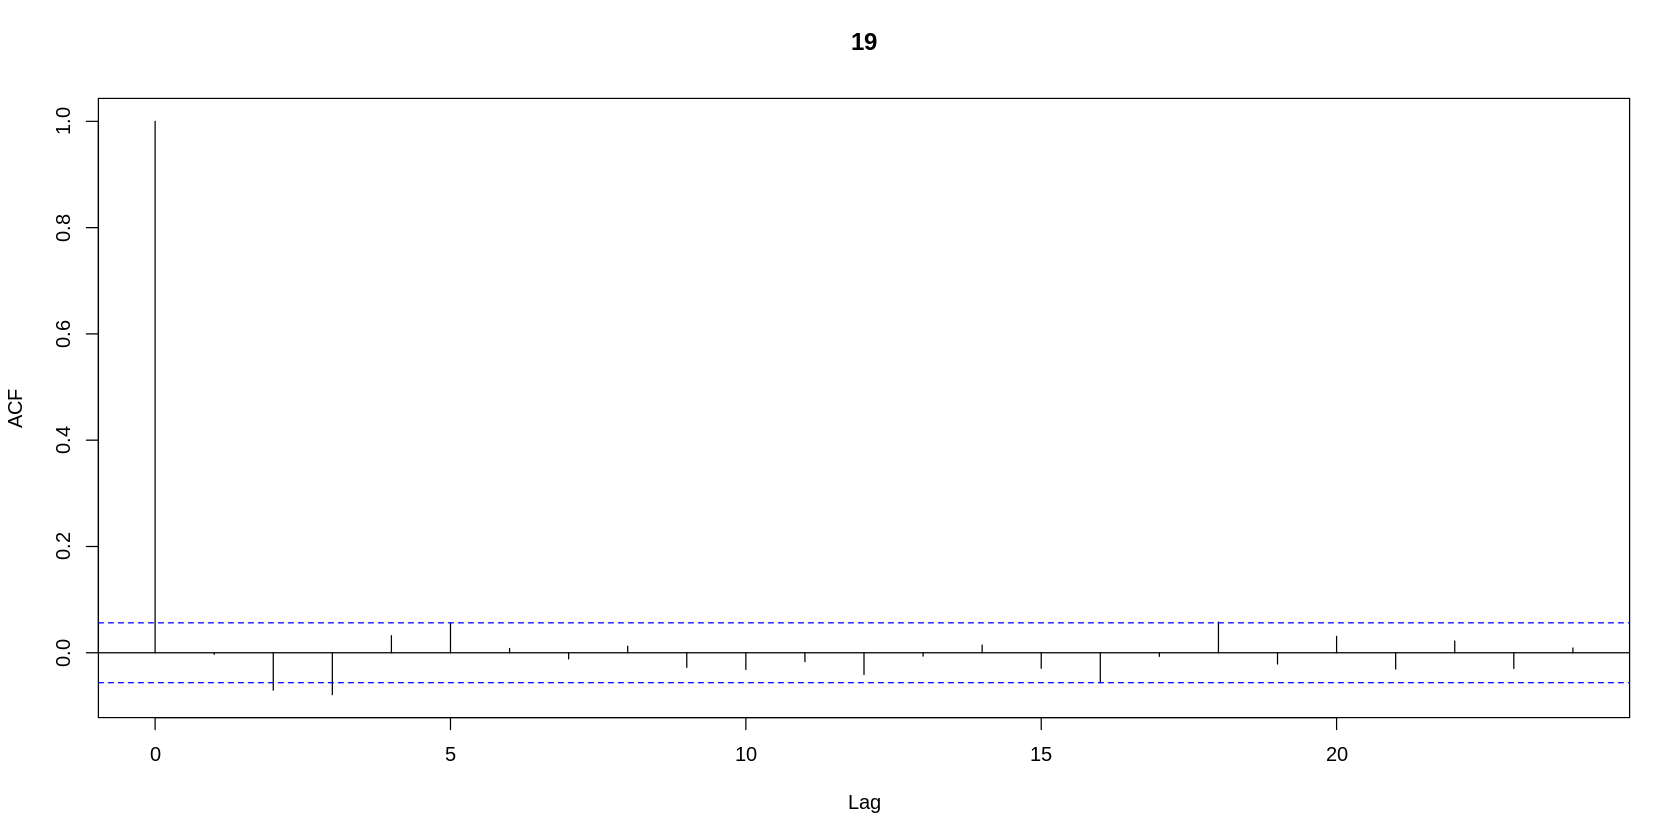

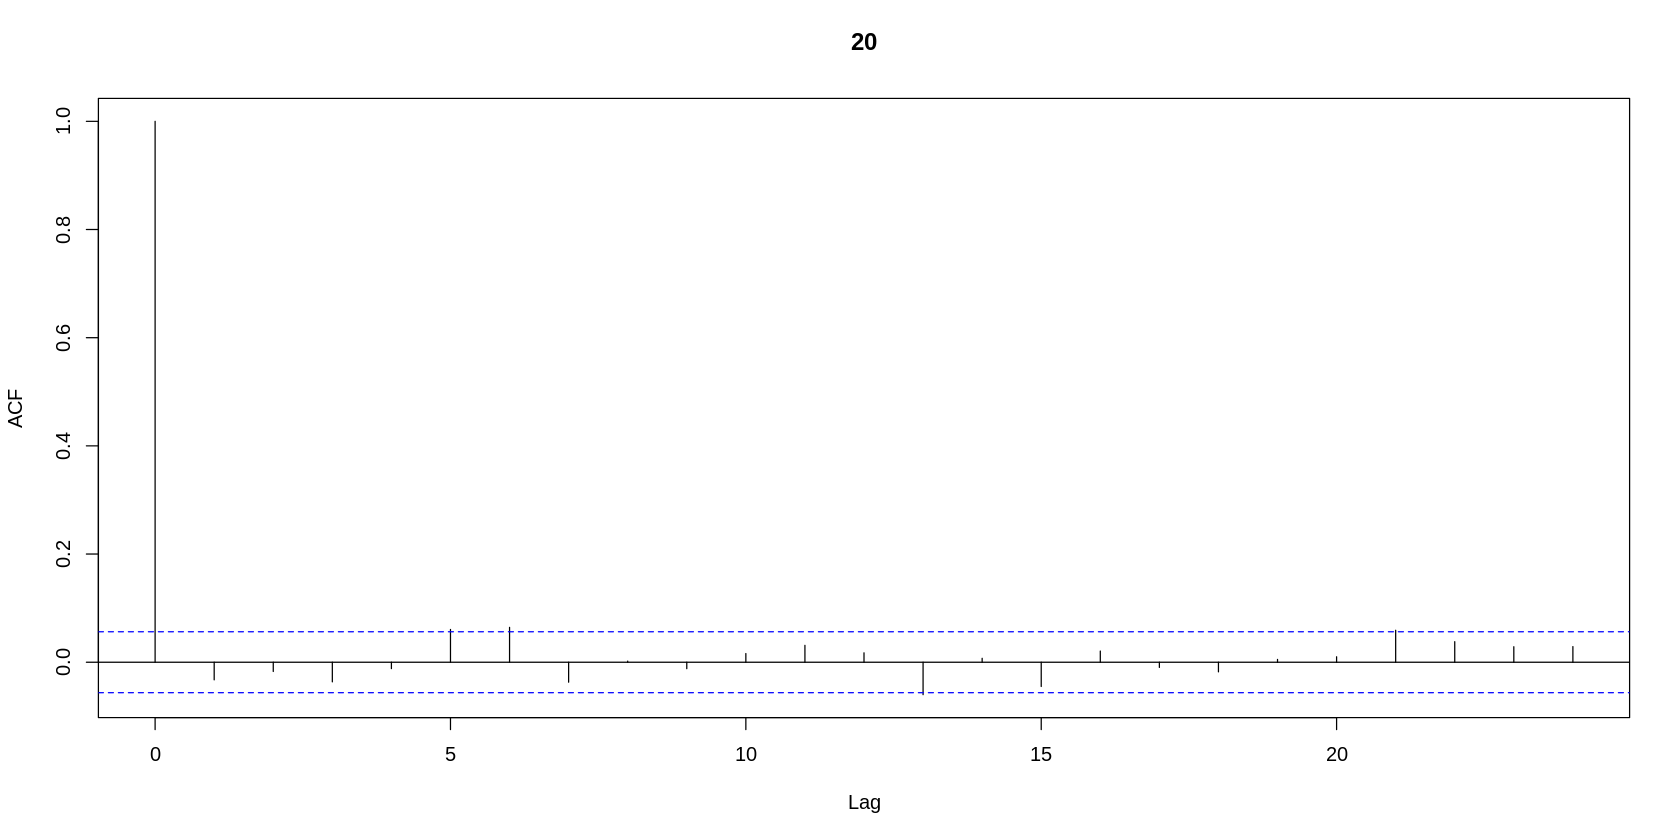

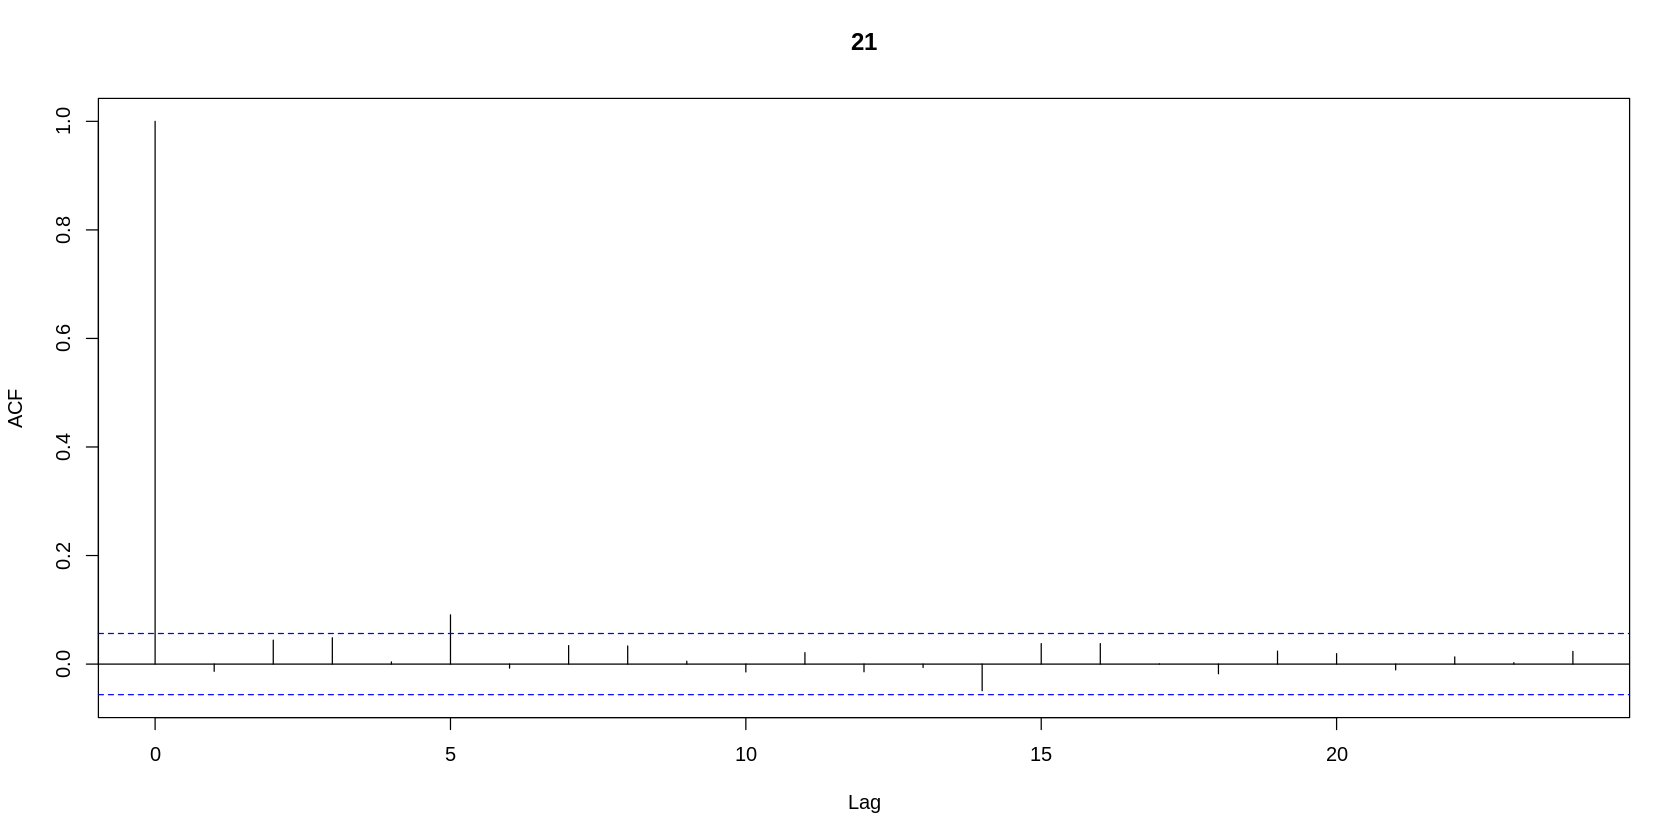

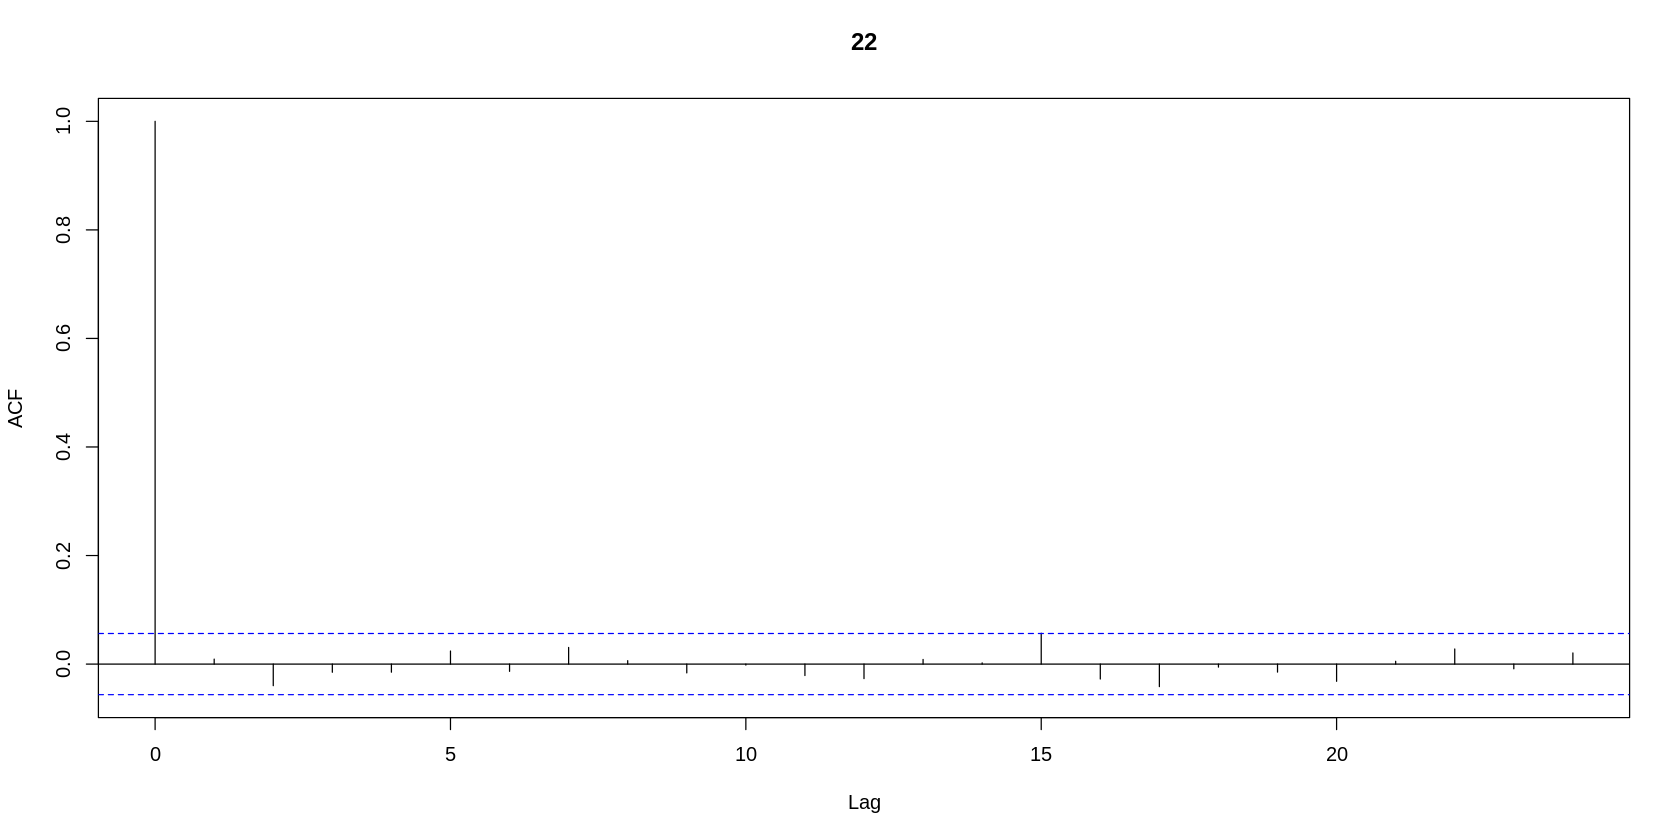

$`0`

Autocorrelations of series '.$c2c_logreturn', by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000 -0.052  0.007 -0.038 -0.026 -0.022 -0.022 -0.017 -0.040  0.013 -0.010 
    11     12     13     14     15     16     17     18     19     20     21 
 0.066 -0.061  0.030 -0.026  0.000  0.029 -0.062 -0.018 -0.013  0.022  0.015 
    22     23     24 
-0.002 -0.043 -0.008 

$`1`

Autocorrelations of series '.$c2c_logreturn', by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000 -0.028  0.040 -0.028 -0.031  0.043  0.007  0.012  0.012 -0.039 -0.023 
    11     12     13     14     15     16     17     18     19     20     21 
-0.007  0.045  0.057 -0.041  0.064  0.018 -0.004 -0.031 -0.010  0.032 -0.016 
    22     23     24 
-0.006 -0.013  0.010 

$`2`

Autocorrelations of series '.$c2c_logreturn', by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000 -0.028  0.011 -0.024 

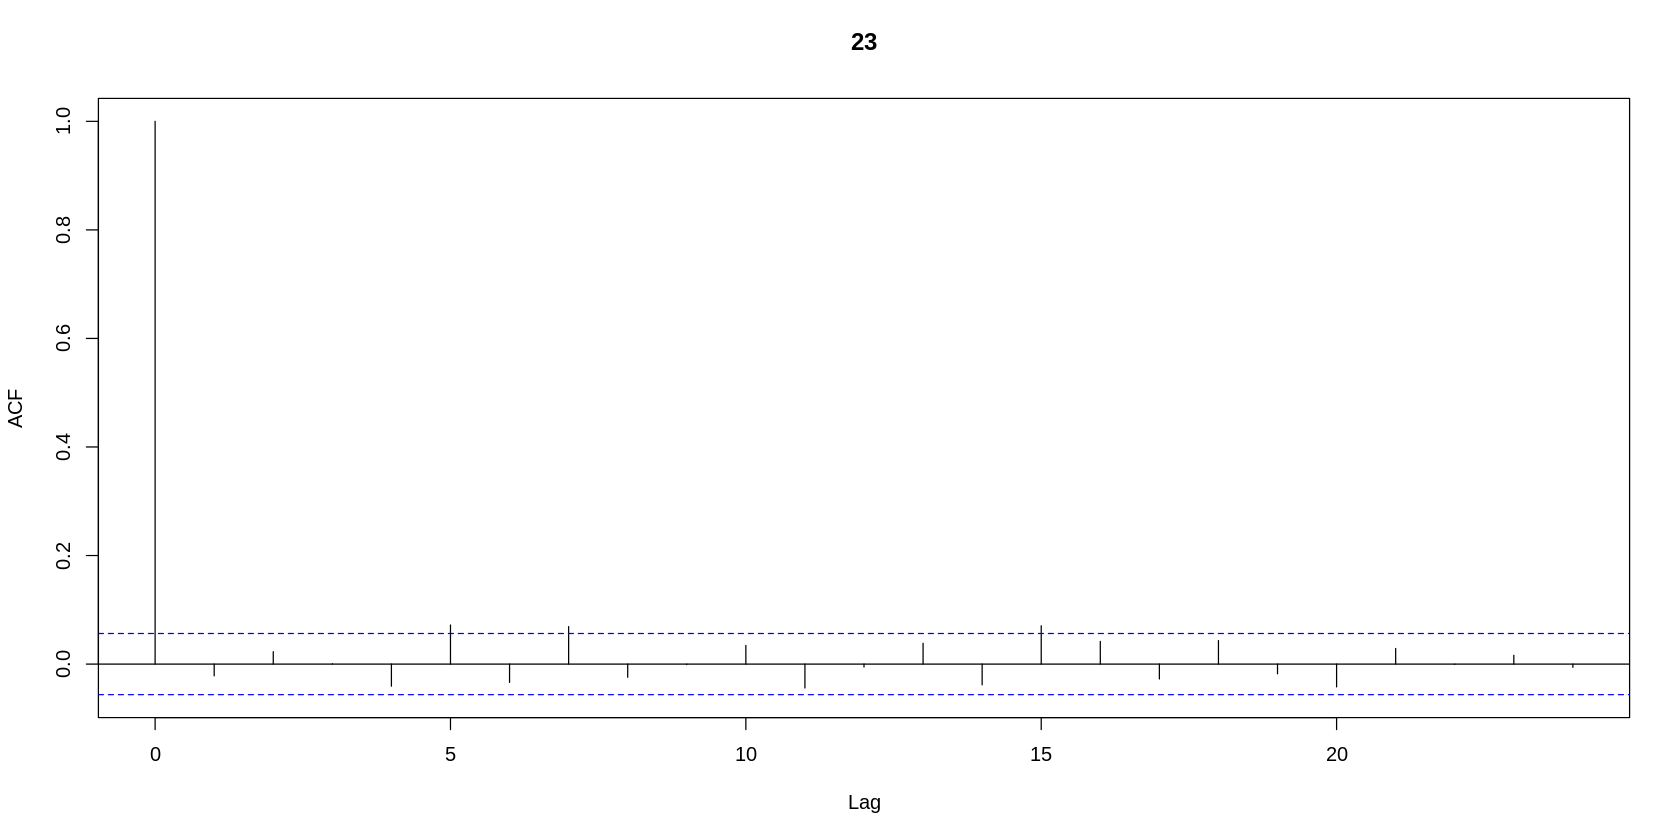

In [20]:
spot %>%
  group_by(ticker)%>%
  filter(ticker %in% c('BTC/USD')) %>%
  arrange(date) %>%
  mutate(
    hour = factor(lubridate::hour(date)),
    dayofweek = factor(lubridate::wday(date)), 
    c2c_simplereturn = close / lag(close) - 1,
    c2c_logreturn = log(close/lag(close)),
  ) %>%
  na.omit() %>%
  arrange(date)%>%
  group_by(ticker,hour)%>%
  arrange(date) %>% 
  split(.$hour) %>% 
  map(~acf(.$c2c_logreturn, main = unique(.$hour),lag.max = 24))

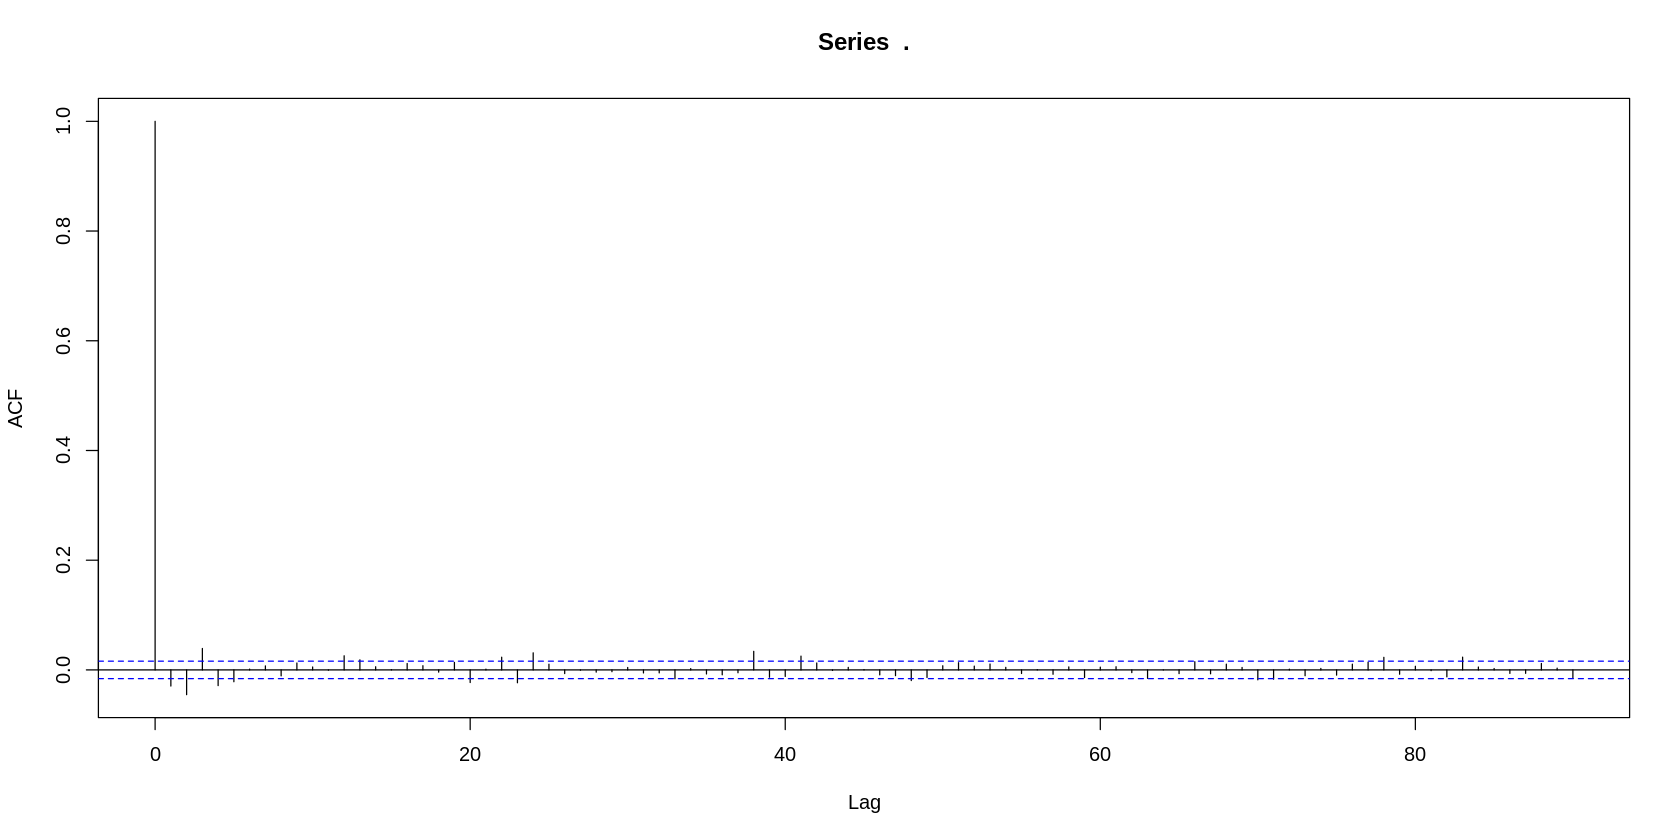

In [22]:
spot %>%
  group_by(ticker)%>%
  filter(ticker %in% c('BTC/USD')) %>%
  arrange(date) %>%
  mutate(
    hour = factor(lubridate::hour(date)),
    dayofweek = factor(lubridate::wday(date)), 
    c2c_simplereturn = close / lag(close) - 1,
    c2c_logreturn = log(close/lag(close)),
  ) %>%
  na.omit() %>%
  mutate(strat_return = case_when(hour %in% c(18,19,20,21) ~ c2c_simplereturn,dayofweek %in% c(2,4,6) ~ c2c_simplereturn, TRUE ~ 0)) %>%
  group_by(date) %>%
   filter(strat_return!=0)%>%
  pull(strat_return) %>%
  acf(lag.max = 90)